In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os

import myplotcreator as myplot
import utils
import gifcreator

# Is the market working as intended?

In [2]:
def DemandBuilder(t, plants_df, demand_type = 'constant', total_capacity_fraction = None):

        if demand_type == 'constant':
            total_capacity = plants_df['capacity'].sum()
            if total_capacity_fraction == None:
                 demand = total_capacity*0.5
            else:
                 demand = total_capacity*total_capacity_fraction

        if demand_type == 'sinusoidal':
            total_capacity = plants_df['capacity'].sum()
            period = 200
            demand = 0.5*total_capacity + 1/3*total_capacity*np.sin(2*np.pi/period * t)

        if demand_type == '2periods':
            total_capacity = plants_df['capacity'].sum()
            long_period = 365*4
            short_period = 4
            demand = 0.5*total_capacity + 1/3*total_capacity*np.sin(2*np.pi/long_period * t) +  1/6*total_capacity*np.cos(2*np.pi/short_period * t)
        
        if demand_type == 'noisy-constant':
            total_capacity = plants_df['capacity'].sum()
            gaussian_noise = random.gauss(0, 1)
            demand = total_capacity*0.5 + 1/10*total_capacity*gaussian_noise
              
        return demand

In [3]:
N = 50 #total number of plants
M = 10 #total number of firms

price_increment = 10 #discretization of bid space

min_price = 0 
max_price = 1000

J = int((max_price-min_price)/(price_increment)+1) #total number of actions (prices)

epsilon = 0.89
r = 0.07
psi = 0.7
s1 = 700000

ER_params = [epsilon, r, psi, s1]

costs_management = 'both_costs'
run_type = 'single'
demand_type = 'constant'
database_path = './Data/Norm_LogNormDataset.csv'

In [4]:
'''
N = 2 #total number of plants
M = 1 #total number of firms

price_increment = 300 #discretization of bid space

min_price = 0 
max_price = 900

J = int((max_price-min_price)/(price_increment)+1) #total number of actions (prices)
database_path = f'./Data/Debugging/{N}_equal_independent_plants.csv' 
'''


"\nN = 2 #total number of plants\nM = 1 #total number of firms\n\nprice_increment = 300 #discretization of bid space\n\nmin_price = 0 \nmax_price = 900\n\nJ = int((max_price-min_price)/(price_increment)+1) #total number of actions (prices)\ndatabase_path = f'./Data/Debugging/{N}_equal_independent_plants.csv' \n"

In [5]:
plants_info_df = pd.read_csv(database_path)
#initializing stuff
plant_IDs = plants_info_df['plantID'].tolist()
plant_capacities = plants_info_df['capacity'].tolist()
#plant_capacities_dict = utils.load_from_plant_csv(database_path, 'capacity')
plant_capacities_arr = plants_info_df['capacity'].to_numpy()
#plant_fixed_costs_dict = utils.load_from_plant_csv(database_path, 'fixed_cost')
#    plant_variable_costs_dict = utils.load_from_plant_csv(database_path, 'variable_cost')
q = np.zeros((N,J))
p = np.zeros((N,J))
normalization = np.zeros(N)
k = np.zeros(N, dtype=int)
R = np.zeros(N)
profits = np.zeros(N)
marginal_prices_through_time = []

#initializing action space
actions_space = np.tile(np.arange(J), (N, 1))

#initializing propensities and probabilities
for i in range(N): #i are plants
    for j in range(J): #j are bids
        q[i,j] = s1

for i in range(N):
    normalization[i] = np.sum(q[i, :])

for i in range(N):
    for j in range(J):
        p[i,j] = q[i,j]/normalization[i]

In [6]:
seed = 59 #12 1 marginal plant,  59 2 marginal plants
np.random.seed(seed) 

t=1

#restrict action space by computing costs first
plant_fixed_costs_arr = plants_info_df['fixed_cost'].to_numpy()
if costs_management != 'fixed_costs_only':
    plant_variable_costs_per_mwh_arr = plants_info_df['variable_cost'].to_numpy(dtype=np.float64)
plant_activation_costs = np.zeros(N)
plant_activation_costs_per_mwh = np.zeros(N)
if costs_management == 'fixed_costs_only':
    plant_activation_costs = plant_fixed_costs_arr
elif costs_management == 'variable_costs_only':
    plant_activation_costs = plant_variable_costs_per_mwh_arr*plant_capacities_arr
else:
    #plant_fixed_costs_arr = convert_fixed_costs(plant_fixed_costs_arr, timestep_in_days)
    plant_variable_costs_arr = plant_variable_costs_per_mwh_arr*plant_capacities_arr
    plant_activation_costs = plant_variable_costs_arr + plant_fixed_costs_arr

#draw action (price)
k = np.zeros(N, dtype=int)
plant_activation_costs_per_mwh = plant_activation_costs/plant_capacities_arr
for plant in plant_IDs:
    while k[plant]*price_increment <= plant_activation_costs_per_mwh[plant]:
        k[plant] = np.random.choice(actions_space[plant], p = p[plant])
        #if k[plant]*price_increment <= plant_activation_costs[plant]: 
        #    print(f'{plant} tried to sell at {k[plant]*price_increment} while it spends {plant_activation_costs[plant]}')
        if plant_activation_costs_per_mwh[plant] > (J-1)*price_increment:
            raise RuntimeError(f'Plant {plant} could not bid hoping for a profit. Simulation interrupted.')
bids = (k*price_increment).tolist()
plant_activation_costs_per_mwh_list = plant_activation_costs_per_mwh.tolist()

#supply curve
supply_df = pd.DataFrame({
    'plant_ID': plant_IDs,
    'capacity': plant_capacities,
    'plant_cost': plant_activation_costs_per_mwh_list,
})
if costs_management == 'fixed_costs_only':
    supply_df['fixed_cost'] = plant_fixed_costs_arr
elif costs_management == 'variable_costs_only':
    supply_df['variable_cost'] = plant_variable_costs_per_mwh_arr
else:
    supply_df['fixed_cost'] = plant_fixed_costs_arr
    supply_df['variable_cost'] = plant_variable_costs_per_mwh_arr
supply_df['bid'] = bids
sorted_by_bid_supply_df = supply_df.sort_values(by='bid')

#demand curve
demand = DemandBuilder(t, plants_info_df, demand_type)

#solving the market
dispatched_capacity = 0
marginal_price = 0
dispatch_schedule = []
marginal_plants = []

for index, row in sorted_by_bid_supply_df.iterrows():
    if dispatched_capacity >= demand:
        break
    plant_ID = row['plant_ID']
    capacity = row['capacity']
    bid_price = row['bid']
    # Dispatch the plant
    if dispatched_capacity + capacity < demand and not marginal_plants: #the plant is not going to offer at marginal price 
        dispatch_schedule.append((int(plant_ID), capacity, bid_price))
        dispatched_capacity += capacity
        marginal_price = bid_price
    else:
        remaining_demand = demand - dispatched_capacity
        if marginal_plants == []:
            marginal_price = bid_price
            if remaining_demand >= 0:
                marginal_plants.append((int(plant_ID), capacity, bid_price))
        else:
            if bid_price == marginal_price:
                if remaining_demand >= 0:
                    marginal_plants.append((int(plant_ID), capacity, bid_price))
            else: 
                break
print(marginal_plants)
print(marginal_price)
if dispatched_capacity < demand and marginal_plants: # marginal plants exist and demand is not met
    remaining_demand = demand - dispatched_capacity
    total_marginal_capacity = sum(plant[1] for plant in marginal_plants)
    for plant_ID, capacity, bid_price in marginal_plants:
        proportional_dispatch = (capacity/total_marginal_capacity) * remaining_demand
        print(proportional_dispatch)
        dispatch_schedule.append((int(plant_ID), min(capacity, proportional_dispatch), bid_price))
        dispatched_capacity += min(capacity, proportional_dispatch)

print(dispatched_capacity)

supply_df['dispatched'] = False
supply_df['selling_price'] = 0
supply_df['supplied_capacity'] = 0.
supply_df['profit'] = 0.
for plant_ID, capacity, _ in dispatch_schedule:
    supply_df.loc[supply_df['plant_ID'] == plant_ID, 'dispatched'] = True
    supply_df.loc[supply_df['plant_ID'] == plant_ID, 'supplied_capacity'] = capacity
    supply_df.loc[supply_df['plant_ID'] == plant_ID, 'selling_price'] = marginal_price
    supply_df.loc[supply_df['plant_ID'] == plant_ID, 'profit'] = ((supply_df['selling_price'] - supply_df['plant_cost'])*supply_df['supplied_capacity']).round(2)

#computing profits (if negative, 0 is displayed)
sorted_by_plantID_supply_df = supply_df.sort_values(by='plant_ID')
profits = sorted_by_plantID_supply_df['profit'].tolist()

[(13, 276.0, 450.0), (44, 189.0, 450.0)]
450.0
60.541935483870965
41.45806451612903
4975.0


In [7]:
supply_df.head()

plant_ID  capacity  plant_cost  fixed_cost  variable_cost  bid  dispatched  \
0         0       199   15.615930        9.14          15.57  930       False   
1         1       123    3.988780       12.15           3.89  150        True   
2         2       590   21.126153        9.53          21.11  870       False   
3         3       301   66.733156        6.97          66.71   80        True   
4         4       102    3.581569       21.58           3.37  570       False   

   selling_price  supplied_capacity     profit  
0              0                0.0       0.00  
1            450              123.0   54859.38  
2              0                0.0       0.00  
3            450              301.0  115363.32  
4              0                0.0       0.00

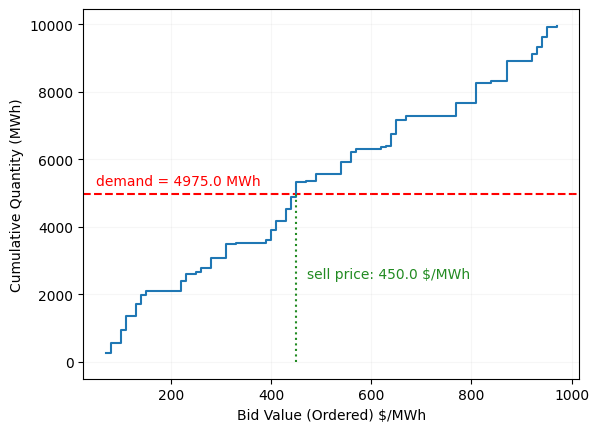

In [8]:
plt.step(sorted_by_bid_supply_df['bid'].to_numpy(), np.cumsum(sorted_by_bid_supply_df['capacity']), where='post')
plt.axhline(demand, color = 'red', linestyle = '--', zorder = 0)
plt.vlines(marginal_price, ymin=0, ymax=dispatched_capacity, color = 'forestgreen', linestyle=':')
plt.xlabel("Bid Value (Ordered) $/MWh")
plt.ylabel("Cumulative Quantity (MWh)")
plt.text(50, demand*1.05, f'demand = {demand} MWh', color='red', ha='left')
plt.text(marginal_price*1.05, demand/2, f'sell price: {marginal_price} $/MWh', color='forestgreen')
plt.grid(alpha=0.1)
plt.show()

# Let's test the algorithm in simple cases

In [6]:
from easy_access_model import Model

## Checking behaviour for a special parameter value
We can start by setting $\varepsilon=1$, the expected behavior is that agents do not learn and keep bidding at random (no reinforcement comes into play). 

_Note:_ We use data that has already been generated as input.

In [4]:
seed = 12
np.random.seed(seed)
N = 50 #total number of plants
M = 10 #total number of firms

price_increment = 10 #discretization of bid space

min_price = 0 
max_price = 1000

J = int((max_price-min_price)/(price_increment)+1) #total number of actions (prices)

epsilon = 1.
r = 0.07
psi = 0.7
s1 = 700000

ER_params = [epsilon, r, psi, s1]

costs_management = 'both_costs'
run_type = 'single'
timestep_in_days = 1

t_max = 600
demand_type = 'constant'
output_path = './Simulation_Results/'

database_path = './Data/Norm_LogNormDataset.csv'

In [5]:
simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)

In [6]:
possession_probs = []
for firm in range(M):
    possession_probs.append(np.random.uniform(0,1))

firm_portfolios_dict, plant_ownership_dict = simulation.FirmPortfoliosCreation(database_path, possession_probs)

entries_dict = {'plants_owned': None, 'total_capacity': 'capacity', 'total_fixed_cost': 'fixed_cost', 'total_variable_cost': 'variable_cost'}
corresponding_data_columns = ['']
structured_firm_dict = {}
plants_info_df = pd.read_csv(database_path)
for firm in firm_portfolios_dict.keys():
    structured_firm_dict[firm] = {}
    for entry in entries_dict.keys():
        if entry == 'plants_owned':
            structured_firm_dict[firm][entry] = firm_portfolios_dict[firm]
        else: 
            total_quantity = 0
            for plant in firm_portfolios_dict[firm]:
                plant_quantity = plants_info_df.loc[plant, entries_dict[entry]]
                total_quantity += plant_quantity
            structured_firm_dict[firm][entry] = total_quantity 

All plants were assigned to firms. No more plants left.


In [ ]:
csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, output_path)
plot_saving_directory = fr'./Figures/single_run_with_eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}/'

In [ ]:
prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')

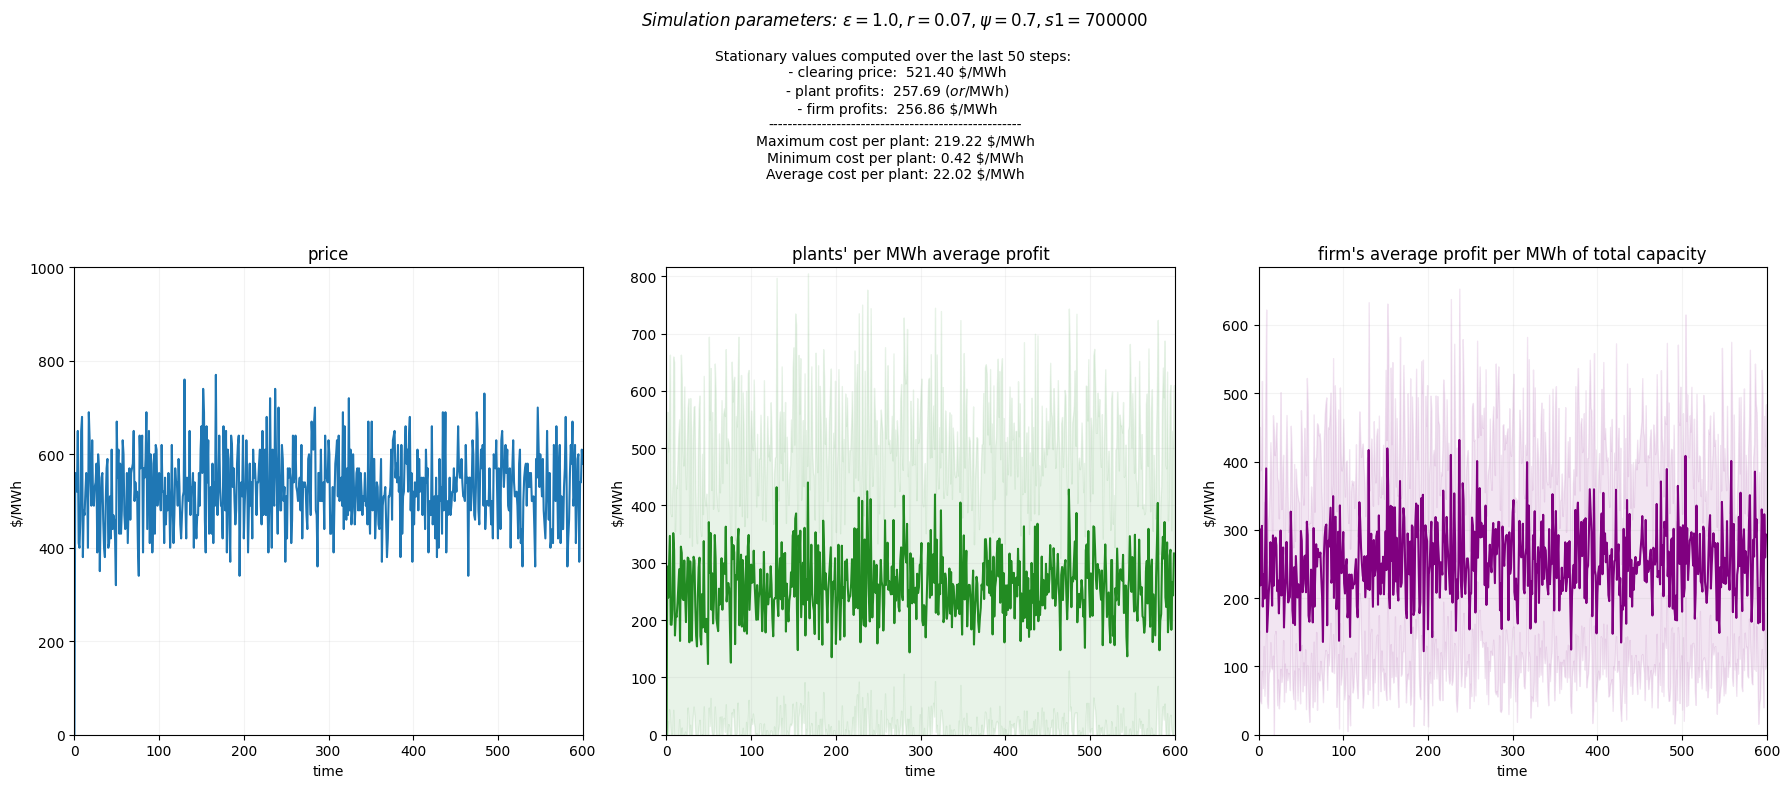

Plot not saved. Remember to set should_save to True if you want to save it.


In [ ]:
myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management)

## Let's now move to test the model in simple scenarios

We start by considering a simple scenario where equal and independent plants can only bid at a loss, with a small gain, with a much greater gain:
- 4 theoretically possible bids: 0 \$/MWh, 300 \$/MWh, 600 \$/MWh, 900 \$/MWh
- same costs: just a bit more than 300 $/MWh => only the latter two bids are available to each plant
- each plant owns itself only

_Note_: things should not change by varying for $\psi$ (and they do not, I made a very quick trial)

In [74]:
seed = 12
np.random.seed(seed)
N = 2 #total number of plants
M = N #total number of firms

price_increment = 300 #discretization of bid space

min_price = 0 
max_price = 900

J = int((max_price-min_price)/(price_increment)+1) #total number of actions (prices)

epsilon = 0.89
r = 0.07
psi = 0.7
s1 = 700000

ER_params = [epsilon, r, psi, s1]

costs_management = 'both_costs'
run_type = 'single'
timestep_in_days = 1

t_max = 600
demand_type = 'constant'
output_path = './Simulation_Results/Debug/'

In [75]:
#simulation = debugging_Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)

In [76]:
database_path = f'./Data/Debugging/{N}_equal_independent_plants.csv'
columns = ['plantID','capacity','fixed_cost','variable_cost']
data = []
for plant in range(N):
    fake_plant_data = [plant, 100, 10, 300]
    data.append(fake_plant_data)

plants_info_df = pd.DataFrame(data, columns=columns)
plants_info_df.to_csv(database_path)

In [77]:
possession_probs = []
for firm in range(M):
    #possession_probs.append(np.random.uniform(0,1))
    possession_probs.append(1)

firm_portfolios_dict, plant_ownership_dict = simulation.FirmPortfoliosCreation(database_path, possession_probs)

entries_dict = {'plants_owned': None, 'total_capacity': 'capacity', 'total_fixed_cost': 'fixed_cost', 'total_variable_cost': 'variable_cost'}
corresponding_data_columns = ['']
structured_firm_dict = {}

for firm in firm_portfolios_dict.keys():
    structured_firm_dict[firm] = {}
    for entry in entries_dict.keys():
        if entry == 'plants_owned':
            structured_firm_dict[firm][entry] = firm_portfolios_dict[firm]
        else: 
            total_quantity = 0
            for plant in firm_portfolios_dict[firm]:
                plant_quantity = plants_info_df.loc[plant, entries_dict[entry]]
                total_quantity += plant_quantity
            structured_firm_dict[firm][entry] = total_quantity 

All plants were assigned to firms. No more plants left.


In [78]:
csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, output_path)
plot_saving_directory = fr'./Figures/Debugging/single_run_with_eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}/'

...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
Results stored here:
 - chosen_action_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/chosen_action_data.csv
 - bid_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/bid_data.csv
 - plant_profits_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/plant_profits_data.csv
 - firm_profits_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/firm_profits_data.csv
 - price_data: ./Simulation_Results/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/prices.csv


In [79]:
prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')

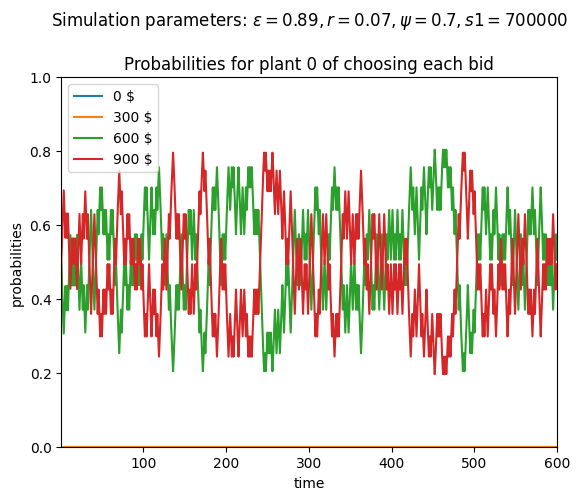

Plot not saved. Remember to set should_save to True if you want to save it.


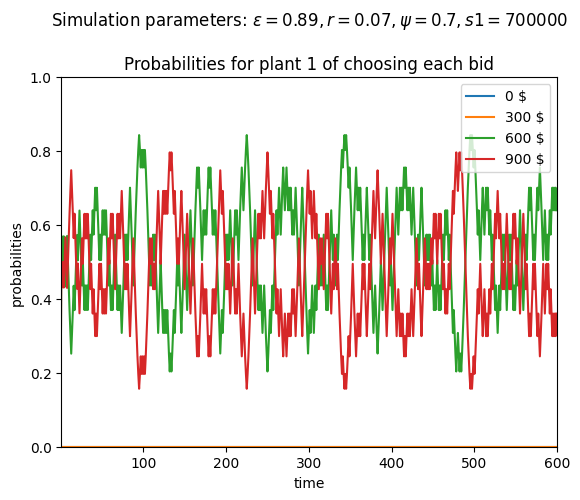

Plot not saved. Remember to set should_save to True if you want to save it.


In [80]:
plant_list = [0,1]
myplot.bid_probabilities_over_time(prob_data, plant_list, price_increment, t_max, J, ER_params)

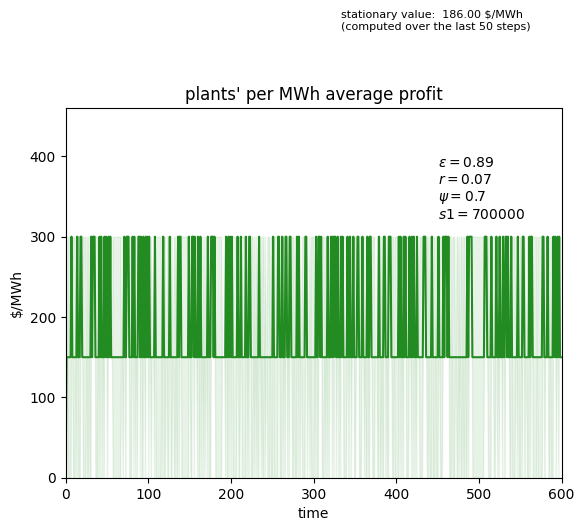

Plot not saved. Remember to set should_save to True if you want to save it.


In [81]:
myplot.average_plant_profits(database_path, plant_profits_data, N, t_max, ER_params, profits_per='MWh', color = 'forestgreen', should_save = False, save_path = '', should_show = True)

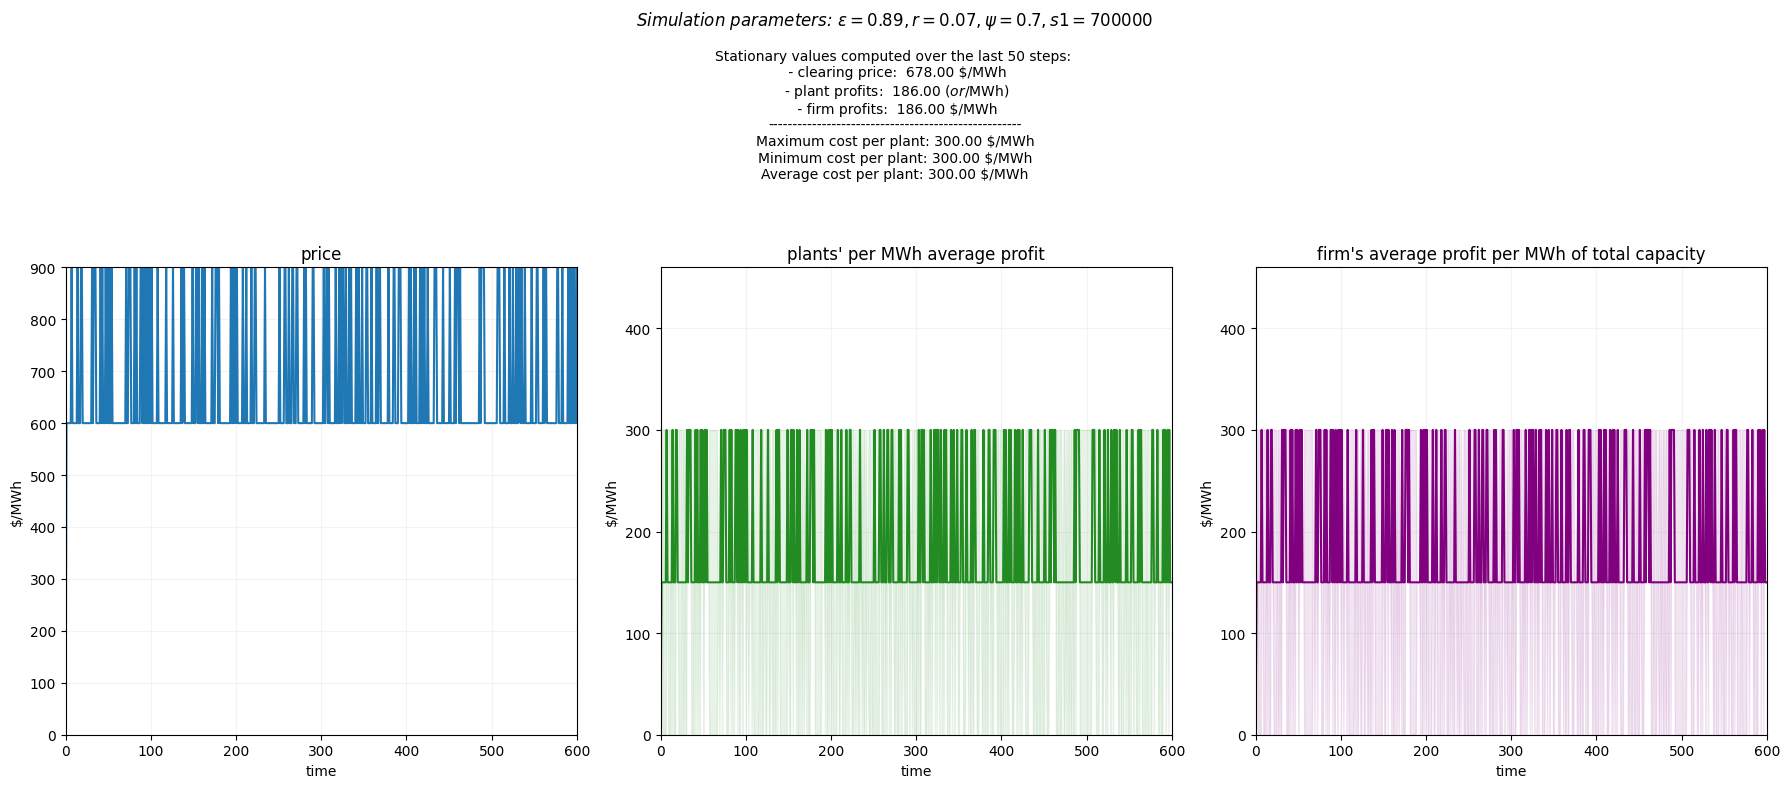

Plot not saved. Remember to set should_save to True if you want to save it.


In [82]:
myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management)

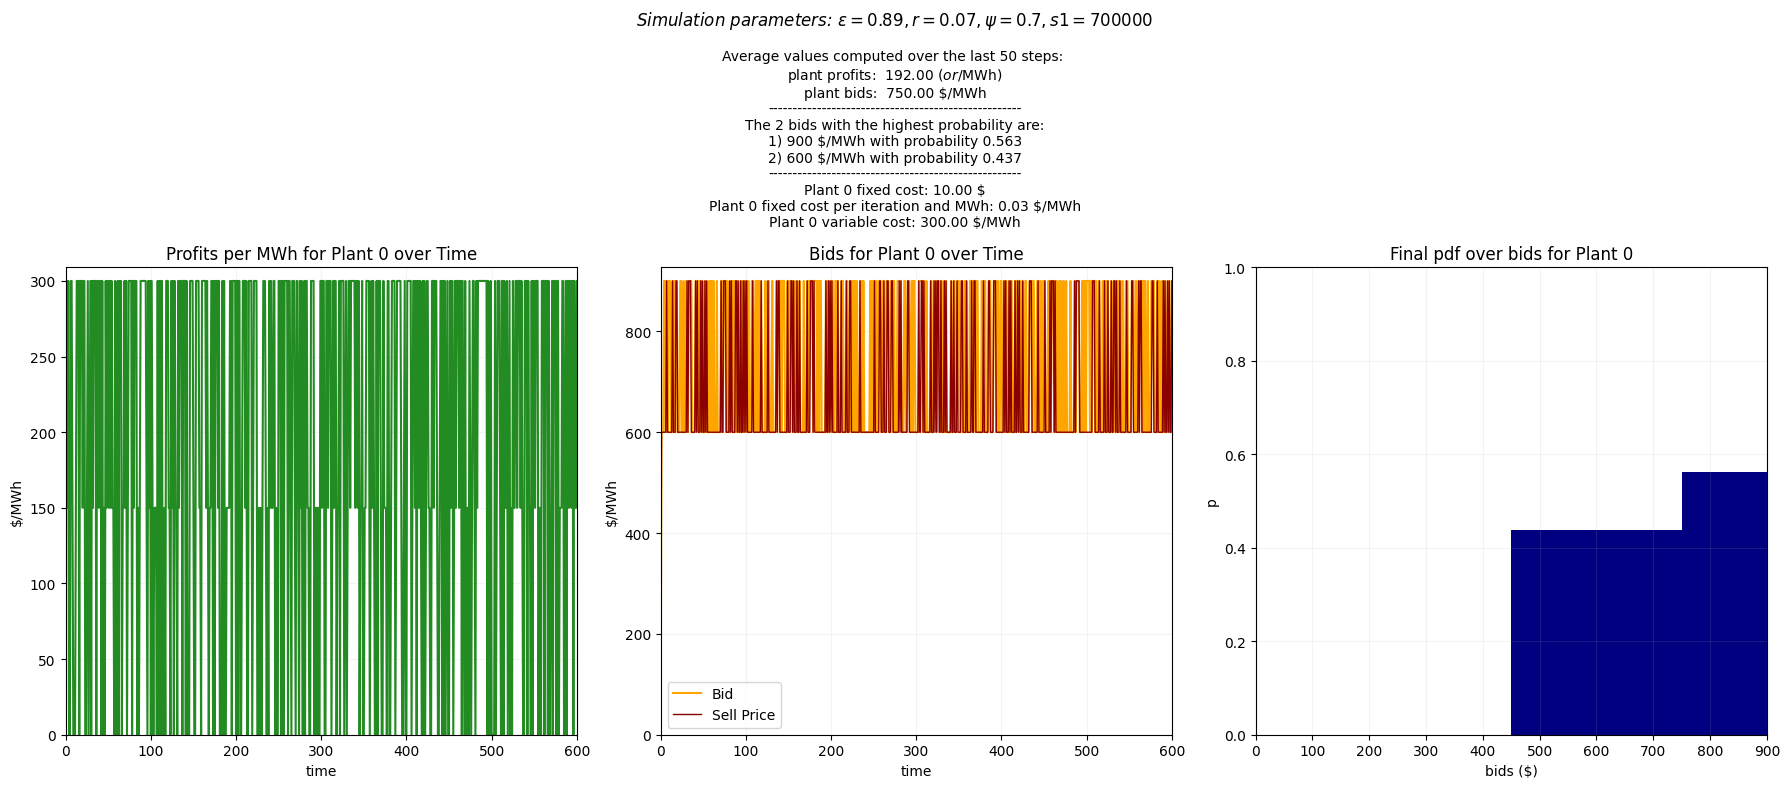

Plot not saved. Remember to set should_save to True if you want to save it.


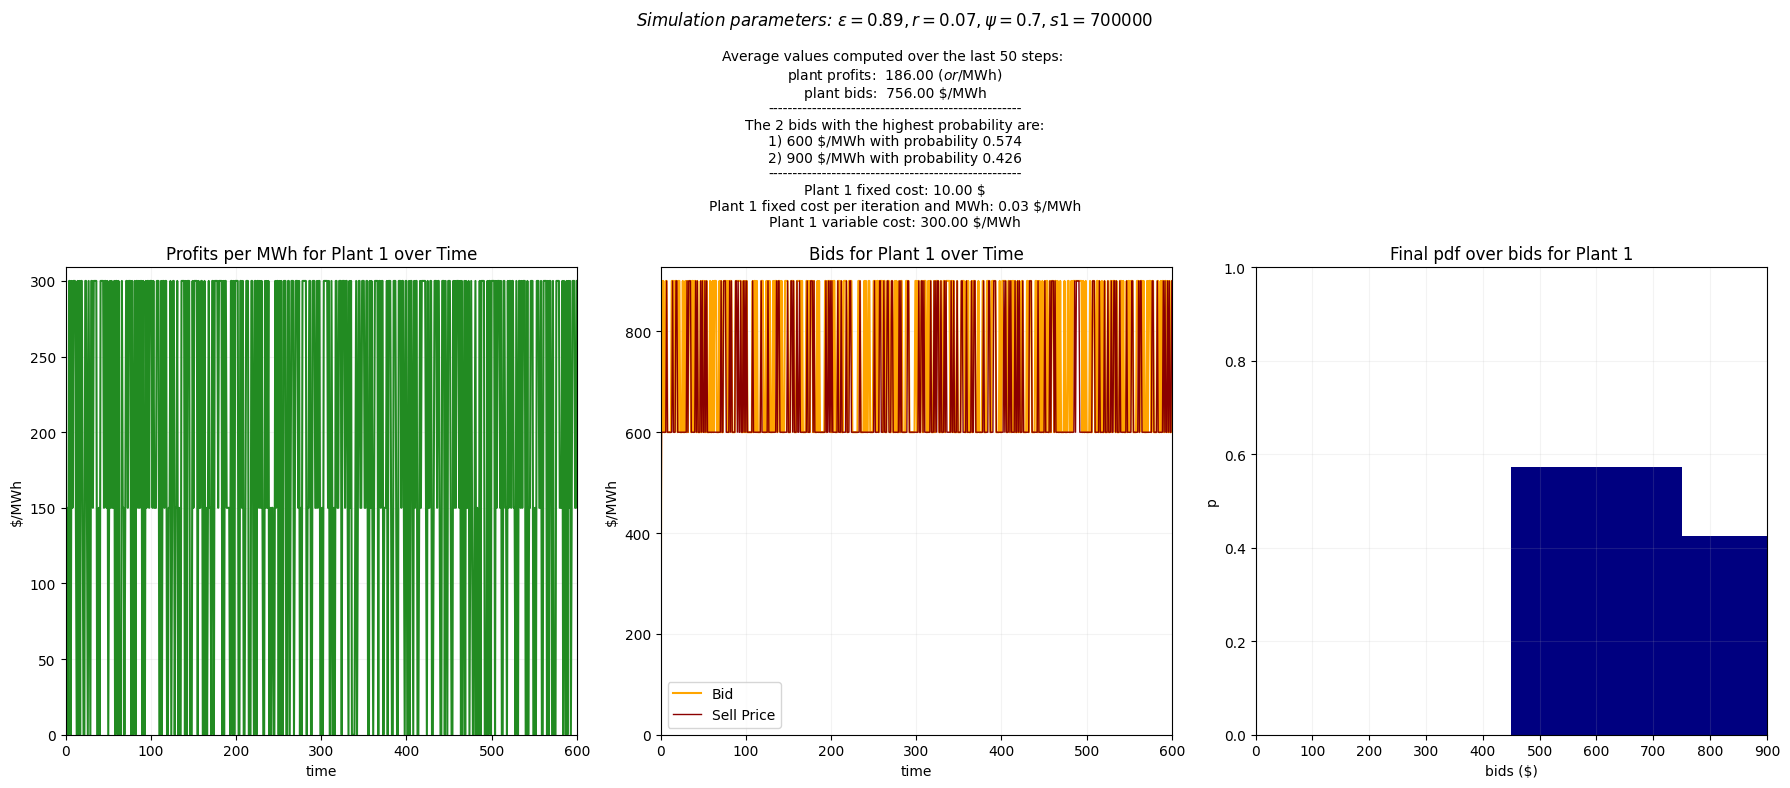

Plot not saved. Remember to set should_save to True if you want to save it.


In [83]:
save_path = ''
plant_ID = 0
myplot.plant_overview(database_path, plant_ID, t_max, plant_profits_data, bid_data, price_increment, prices_data_list, prob_data, ER_params, profits_per = 'MWh', timestep_in_days = timestep_in_days, should_save = False, save_path = save_path, should_show = True)
plant_ID = 1
myplot.plant_overview(database_path, plant_ID, t_max, plant_profits_data, bid_data, price_increment, prices_data_list, prob_data, ER_params, profits_per = 'MWh', timestep_in_days = timestep_in_days, should_save = False, save_path = save_path, should_show = True)

In [86]:
import gifcreator
plant_ID = 1
fixed_costs = plants_info_df['fixed_cost'].to_numpy()
plant_fixed_cost = fixed_costs[plant_ID]
gifcreator.single_plant_pdf_evolution(database_path, plant_ID, prob_data, min_price, max_price, price_increment, ER_params, t_max, save_path = plot_saving_directory, time_stamp_every=10, costs_management=costs_management)

c:\Users\harry\Desktop\Unito\Tesi\Avanzamento progressi\05_Toy_Model\gifcreator.py:91: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0,maximum_y_value*2)


Saved 10 frames.
Saved 20 frames.
Saved 30 frames.
Saved 40 frames.
Saved 50 frames.
Saved 60 frames.
I'm done creating the single frames, I will now move to making a gif out of them.


MovieWriter ffmpeg unavailable; using Pillow instead.


GIF saved as ./Figures/Debugging/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/plant_1_pdf_GIF_params_eps_0.89_r_0.07_psi_0.7_s1_700000.gif


In [85]:
gifcreator.pdf_evo_gif_creator(prob_data, min_price, max_price, price_increment, range(N), ER_params, t_max, save_path=plot_saving_directory, time_stamp_every=10)

Saved 10 frames.
Saved 20 frames.
Saved 30 frames.
Saved 40 frames.
Saved 50 frames.
I'm done creating the single frames, I will now move to making a gif out of them.


MovieWriter ffmpeg unavailable; using Pillow instead.


GIF saved as ./Figures/Debugging/single_run_with_eps_0.89_r_0.07_psi_0.7_s1_700000_both_costs/plant_evo_pdf_GIF_params_eps_0.89_r_0.07_psi_0.7_s1_700000.gif


Let's check if nothing changes by varying $\psi$ (it shouldn't as plants and firms are the same entity):

In [ ]:
"""psis = np.arange(0,1.1, 0.1)
csv_filenames_dict = {}
for psi in psis:
    epsilon = 0.89
    r = 0.07
    s1 = 700000

    ER_params = [epsilon, r, psi, s1]
    print(ER_params)

    costs_management = 'both_costs'
    run_type = 'multiple'
    timestep_in_days = 1

    t_max = 500
    demand_type = 'constant'
    output_path = './Simulation_Results/Debug/two_plants_two_firms'

    simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
    csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, output_path, run_ID=0)
    csv_filenames_dict[psi] = csv_filenames

for psi in psis:
    csv_filenames = csv_filenames_dict[psi]
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
    bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    ER_params = [epsilon, r, psi, s1]
    myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management)


## Three plants scenario
We now add an identical plant and let it own by one of the two firms, so that one firm has 2 plants and the other just one.


In [ ]:
def reinforcement_function(plant_ID, psi, profits, plant_ownership_dict, firm_portfolios):
    #recovering the plant ownership
    plant_owner = plant_ownership_dict[plant_ID]
    #recovering all the plants under the same owner
    firm_plant_list = firm_portfolios[plant_owner]
    n = len(firm_plant_list)
    #computing the firm profits
    firm_profit = 0
    for plant in firm_plant_list:
        firm_profit = firm_profit + profits[plant]
    #print(firm_profit)
    #computing reinforcement for the plant
    reinforcement = psi*profits[plant_ID] + (1-psi)*(firm_profit)/n
    return reinforcement

def compute_firm_profits(firms, firm_portfolios, plant_profits):
    firm_profits = [0.0]*len(firms)
    for firm in firms:
        for plant in firm_portfolios[firm]:
            firm_profits[firm] = firm_profits[firm] + plant_profits[plant]
    return firm_profits

class debugging_Model():
    def __init__(self, N, M, J, price_increment, ER_params, seed, costs_management = 'both_costs', timestep_in_days = float(1), run_type = 'single'):
        #Structure
        self.N = N
        self.M = M
        self.J = J
        self.price_increment = price_increment

        #Roth&Erev parameters
        self.epsilon = ER_params[0]
        self.r = ER_params[1]
        self.psi = ER_params[2]
        self.s1 = ER_params[3]

        #Time
        self.t = 0 

        self.costs_management = costs_management
        self.seed = seed
        self.run_type = run_type
        self.timestep_in_days = timestep_in_days

    def DatasetCreator(self, path, distributions):
        #Preparing file where to store data
        filepath = path + 'Norm_LogNormDataset.csv'
        f = open(filepath, 'w')
        f.write('plantID,capacity,fixed_cost,variable_cost\n')

        j=0
        while j < 50: # self.N: #loop over plants
            keep_trying = True
            while keep_trying != False:
            #sampling a capacity in the distribution of capacities
                sampled_capacity = np.random.normal(distributions['capacity']['mean'], distributions['capacity']['std_dev'])
                sampled_fixed_cost = np.random.lognormal(distributions['fixed_cost']['mu'], distributions['fixed_cost']['sigma'])
                sampled_variable_cost = np.random.lognormal(distributions['variable_cost']['mu'], distributions['variable_cost']['sigma'])
                if sampled_capacity > 10 and sampled_fixed_cost <= distributions['fixed_cost']['max'] and sampled_variable_cost <= distributions['variable_cost']['max']:
                    keep_trying = False
            #saving 
            line = "%i,%i,%.2f,%.2f\n"%(j, sampled_capacity, sampled_fixed_cost, sampled_variable_cost)
            f.write(line)
            j += 1

        f.close()
        print(f'Dataset created. Location: {filepath}')

    def FirmPortfoliosCreation(self, database_path, possession_probs):
        np.random.seed(self.seed)
        df = pd.read_csv(database_path)
        #initialization
        plantIDs = df['plantID'].tolist()
        updated_plantIDs = plantIDs.copy()
        firm_portfolios = {firm_ID: [] for firm_ID in range(self.M)}
        plant_ownership_dict_prov= {}
        plant_ownership_dict = {}
        #assigning first plant
        for firm in range(self.M):
            #selecting plant
            selected_plant = np.random.choice(updated_plantIDs)
            #inserting plant in firm's portfolio
            firm_portfolios[firm].append(selected_plant)
            #updating list of ownerless plants
            updated_plantIDs.remove(selected_plant)
        #assigning all remaning plants
        remaining_plants = len(updated_plantIDs)
        while remaining_plants > 0:
            for firm in range(self.M):
                if updated_plantIDs: #checking if the list is not empty (removing this condition brings up an error)
                    p = np.random.uniform(0,1)
                    if p < possession_probs[firm]:
                        selected_plant = np.random.choice(updated_plantIDs)
                        firm_portfolios[firm].append(selected_plant)
                        updated_plantIDs.remove(selected_plant)
                        remaining_plants = len(updated_plantIDs)
        #making a provisional dictionary 
        for firm, portfolio in firm_portfolios.items():
            for plant in portfolio:
                plant_ownership_dict_prov[plant] = firm
        #create tha final dictionary by sorting the previous one by plant ID
        plant_ownership_dict = {key: plant_ownership_dict_prov[key] for key in sorted(plant_ownership_dict_prov)}
        print("All plants were assigned to firms. No more plants left.")
        return firm_portfolios, plant_ownership_dict
        
    def run(self, database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type='constant', total_capacity_fraction = None, output_path = './Simulation_Results/', run_ID = None):

        np.random.seed(self.seed)
        plants_info_df = pd.read_csv(database_path)
        #initializing stuff
        plant_IDs = plants_info_df['plantID'].tolist()
        plant_capacities = plants_info_df['capacity'].tolist()
#        plant_capacities_dict = utils.load_from_plant_csv(database_path, 'capacity')
        plant_capacities_arr = plants_info_df['capacity'].to_numpy()
#        plant_fixed_costs_dict = utils.load_from_plant_csv(database_path, 'fixed_cost')
#            plant_variable_costs_dict = utils.load_from_plant_csv(database_path, 'variable_cost')
        q = np.zeros((self.N,self.J))
        p = np.zeros((self.N,self.J))
        normalization = np.zeros(self.N)
        k = np.zeros(self.N, dtype=int)
        R = np.zeros(self.N)
        profits = np.zeros(self.N)
        marginal_prices_through_time = []
        marginal_prices_through_time.append(0.0)

        #initializing action space
        actions_space = np.tile(np.arange(self.J), (self.N, 1))

        #initializing propensities and probabilities
        for i in range(self.N): #i are plants
            for j in range(self.J): #j are bids
                q[i,j] = self.s1

        simulation_data_dict = utils.initialize_metrics(plants = range(self.N), firms = range(self.M), t_max = t_max, p = p, k=k)
        #let's run the simulation
        self.t = 0        
        while self.t < t_max:
            #update time
            self.t += 1
            #print(f't={self.t}')

            #restrict action space by computing costs first
            #plant_fixed_costs_arr = plants_info_df['fixed_cost'].to_numpy()
            plant_fixed_costs_arr = utils.convert_fixed_cost(plants_info_df['fixed_cost'].to_numpy(dtype=np.float64), self.timestep_in_days)
            if self.costs_management != 'fixed_costs_only':
                plant_variable_costs_per_mwh_arr = plants_info_df['variable_cost'].to_numpy(dtype=np.float64)
            plant_activation_costs = np.zeros(self.N)
            plant_activation_costs_per_mwh = np.zeros(self.N)
            if self.costs_management == 'fixed_costs_only':
                plant_activation_costs = plant_fixed_costs_arr
            elif self.costs_management == 'variable_costs_only':
                plant_activation_costs = plant_variable_costs_per_mwh_arr*plant_capacities_arr
            else:
                plant_variable_costs_arr = plant_variable_costs_per_mwh_arr*plant_capacities_arr
                plant_activation_costs = plant_variable_costs_arr + plant_fixed_costs_arr
            
            #draw action (price)
            k = np.zeros(self.N, dtype=int)
            plant_activation_costs_per_mwh = plant_activation_costs/plant_capacities_arr
            for plant in plant_IDs:
                if plant_activation_costs_per_mwh[plant] > (self.J-1)*self.price_increment:
                    raise RuntimeError(f'Plant {plant} could not bid hoping for a profit. Simulation interrupted.')
            #reducing action space
            forbidden_actions = {}
            for plant in plant_IDs:
                forbidden_actions[plant] = []
                for j in range(self.J):
                    if j*self.price_increment < plant_activation_costs_per_mwh[plant]:
                        forbidden_actions[plant].append(j)
            #initializing probabilities
            for i in range(self.N):
                highest_forbbiden_action = forbidden_actions[i][-1]
                normalization[i] = np.sum(q[i, highest_forbbiden_action+1:])
            for i in range(self.N):
                accessible_actions = [action for action in list(range(self.J)) if action not in forbidden_actions[i]]
                for j in accessible_actions:
                    p[i,j] = q[i,j]/normalization[i]           

            for plant in plant_IDs:
                k[plant] = np.random.choice(actions_space[plant], p = p[plant])
            bids = (k*self.price_increment).tolist()
            plant_activation_costs_per_mwh_list = plant_activation_costs_per_mwh.tolist()
    
            #supply curve
            supply_df = pd.DataFrame({
                'plant_ID': plant_IDs,
                'capacity': plant_capacities,
                'plant_cost': plant_activation_costs_per_mwh_list,
            })
            if self.costs_management == 'fixed_costs_only':
                supply_df['fixed_cost'] = plant_fixed_costs_arr
            elif self.costs_management == 'variable_costs_only':
                supply_df['variable_cost'] = plant_variable_costs_per_mwh_arr
            else:
                supply_df['fixed_cost'] = plant_fixed_costs_arr
                supply_df['variable_cost'] = plant_variable_costs_per_mwh_arr
            supply_df['bid'] = bids
            sorted_by_bid_supply_df = supply_df.sort_values(by='bid')

            #demand curve
            demand = DemandBuilder(self.t, plants_info_df, demand_type, total_capacity_fraction)

            #solving the market
            dispatched_capacity = 0
            marginal_price = 0
            dispatch_schedule = []
            marginal_plants = []

            for index, row in sorted_by_bid_supply_df.iterrows():
                if dispatched_capacity >= demand:
                    break
                plant_ID = row['plant_ID']
                capacity = row['capacity']
                bid_price = row['bid']
                #dispatching the plant
                if dispatched_capacity + capacity < demand: #demand is not met by the selected plant
                    remaining_plants_df = sorted_by_bid_supply_df[sorted_by_bid_supply_df.index > index]
                    prov_dispatched_capacity = dispatched_capacity + capacity
                    marginal_price = bid_price
                    marginal_plants.append((int(plant_ID), capacity, bid_price))                      
                    for remaining_index, remaining_row in remaining_plants_df.iterrows(): #demand could be met by considering other plants bidding at the same price level
                        next_plant_bid_price = remaining_row['bid']
                        if next_plant_bid_price == bid_price:
                            next_plant_ID = remaining_row['plant_ID']
                            next_plant_capacity = remaining_row['capacity']
                            marginal_plants.append((int(next_plant_ID), next_plant_capacity, bid_price))
                            prov_dispatched_capacity += next_plant_capacity
                        else:
                            break
                    if prov_dispatched_capacity < demand:
                        dispatch_schedule.append((int(plant_ID), capacity, bid_price))
                        dispatched_capacity += capacity
                        marginal_plants = []
                    else:
                        break
                else:
                    remaining_demand = demand - dispatched_capacity
                    if marginal_plants == []:
                        marginal_price = bid_price
                        if remaining_demand >= 0:
                            marginal_plants.append((int(plant_ID), capacity, bid_price))
                    else:
                        if bid_price == marginal_price:
                            if remaining_demand >= 0:
                                marginal_plants.append((int(plant_ID), capacity, bid_price))
                        else: 
                            break

            if dispatched_capacity < demand and marginal_plants: # marginal plants exist and demand is not met
                remaining_demand = demand - dispatched_capacity
                total_marginal_capacity = sum(plant[1] for plant in marginal_plants)
                for plant_ID, capacity, bid_price in marginal_plants:
                    proportional_dispatch = (capacity/total_marginal_capacity) * remaining_demand
                    dispatch_schedule.append((int(plant_ID), min(capacity, proportional_dispatch), bid_price))
                    dispatched_capacity += min(capacity, proportional_dispatch)
            supply_df['dispatched'] = False
            supply_df['selling_price'] = 0
            supply_df['supplied_capacity'] = 0.
            supply_df['profit'] = 0.
            for plant_ID, capacity, _ in dispatch_schedule:
                supply_df.loc[supply_df['plant_ID'] == plant_ID, 'dispatched'] = True
                supply_df.loc[supply_df['plant_ID'] == plant_ID, 'supplied_capacity'] = capacity
                supply_df.loc[supply_df['plant_ID'] == plant_ID, 'selling_price'] = marginal_price
                supply_df.loc[supply_df['plant_ID'] == plant_ID, 'profit'] = ((supply_df['selling_price'] - supply_df['plant_cost'])*supply_df['supplied_capacity']).round(2)

            marginal_prices_through_time.append(marginal_price)
                
            #computing profits (if negative, 0 is displayed)
            sorted_by_plantID_supply_df = supply_df.sort_values(by='plant_ID')
            profits = sorted_by_plantID_supply_df['profit'].tolist()

            #recording simulation data
            firm_profits = compute_firm_profits(firms = range(self.M), firm_portfolios = firm_portfolios_dict, plant_profits = profits)
            simulation_data_dict = utils.update_metrics(plants = range(self.N), firms = range(self.M), t = self.t, p = p, k=k, bids=bids, plant_profits=profits, firm_profits=firm_profits, metrics = simulation_data_dict)

            #compute reinforcement
            for plant in range(self.N):
                R[plant] = reinforcement_function(plant, self.psi, profits, plant_ownership_dict, firm_portfolios_dict)
            #update propensities
            for i in range(self.N):
                for j in range(self.J):
                    if j == k[i]:
                        q[i,j] = (1-self.r)*q[i,j]+R[i]*(1-self.epsilon)
                    else:
                        q[i,j] = (1-self.r)*q[i,j]+q[i,j]*self.epsilon/(self.J-1)
        
            ###in_depth_timestep info
            detailed_observer_text = f"TIMESTEP: {self.t} - Market was cleared at {marginal_price} $/MWh\n"
            for plant in range (self.N):
                detailed_observer_text += f" - Plant {plant} offered {supply_df.loc[plant, 'bid']} $/MWh. It was"
                if supply_df.loc[plant, 'dispatched'] == True:
                    detailed_observer_text += f" dispatched. Its profit was {supply_df.loc[plant, 'profit']: .2f} $ and its reinforcement was {R[plant]}\n"
                else:
                    detailed_observer_text += f" NOT dispatched. Its profit was {supply_df.loc[plant, 'profit']: .2f} $ and its reinforcement was {R[plant]}\n"
            filename = './Debugging_Report.txt'
            if self.t == 1:
                with open (filename, 'w') as record_file:
                    record_file.write("")
            with open(filename, 'a') as record_file:
                record_file.write(detailed_observer_text)
            #print(supply_df)
    
        #creating a subfolder structure if run_type is set to multiple
        if self.run_type == 'multiple':
            output_path = output_path + fr'varying_params/run_with_params_eps_{self.epsilon}_r_{self.r}_psi_{self.psi}_s1_{self.s1}_{self.costs_management}/run_{run_ID}/'
        else:
            output_path = output_path + fr'single_run_with_eps_{self.epsilon}_r_{self.r}_psi_{self.psi}_s1_{self.s1}_{self.costs_management}/'
        #checking if output_path exists, if not creating it
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        csv_filenames = {}
        #saving simulation data
        prob_data = simulation_data_dict['prob_data']
        csv_filenames = utils.save_metrics_to_csv(metrics = simulation_data_dict, t_max = t_max, output_path = output_path, csv_filenames=csv_filenames) #be careful, this functiond deletes prob_data
        #saving prices data
        csv_filenames = utils.save_prices_to_csv(marginal_prices_through_time, t_max, output_path, csv_filenames)                
        if self.run_type == 'single':
            print('Results stored here:')
            formatted_csv_filenames = ' - '
            formatted_csv_filenames = formatted_csv_filenames+'\n - '.join([f"{key}: {value}" for key, value in csv_filenames.items()])
            print(formatted_csv_filenames)
        return csv_filenames, prob_data


In [265]:
seed = 12
np.random.seed(seed)
N = 3 #total number of plants
M = 2 #total number of firms

price_increment = 300 #discretization of bid space

min_price = 0 
max_price = 900

J = int((max_price-min_price)/(price_increment)+1) #total number of actions (prices)

epsilon = 0.89
r = 0.07
psi = 0.3 #0.7
s1 = 700000

ER_params = [epsilon, r, psi, s1]

costs_management = 'both_costs'
run_type = 'single'
timestep_in_days = 1

t_max = 60
demand_type = 'constant'
output_path = './Simulation_Results/Debug/three_plants_two_firms'

In [266]:
simulation = debugging_Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
#simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)

In [267]:
database_path = f'./Data/Debugging/{N}_equal_independent_plants.csv'
columns = ['plantID','capacity','fixed_cost','variable_cost']
data = []
for plant in range(N):
    fake_plant_data = [plant, 100, 10, 300]
    data.append(fake_plant_data)

plants_info_df = pd.DataFrame(data, columns=columns)
plants_info_df.to_csv(database_path)

In [268]:
possession_probs = []
for firm in range(M):
    #possession_probs.append(np.random.uniform(0,1))
    possession_probs.append(1)

firm_portfolios_dict, plant_ownership_dict = simulation.FirmPortfoliosCreation(database_path, possession_probs)

entries_dict = {'plants_owned': None, 'total_capacity': 'capacity', 'total_fixed_cost': 'fixed_cost', 'total_variable_cost': 'variable_cost'}
corresponding_data_columns = ['']
structured_firm_dict = {}

for firm in firm_portfolios_dict.keys():
    structured_firm_dict[firm] = {}
    for entry in entries_dict.keys():
        if entry == 'plants_owned':
            structured_firm_dict[firm][entry] = firm_portfolios_dict[firm]
        else: 
            total_quantity = 0
            for plant in firm_portfolios_dict[firm]:
                plant_quantity = plants_info_df.loc[plant, entries_dict[entry]]
                total_quantity += plant_quantity
            structured_firm_dict[firm][entry] = total_quantity

print(structured_firm_dict)

All plants were assigned to firms. No more plants left.
{0: {'plants_owned': [2, 0], 'total_capacity': 200, 'total_fixed_cost': 20, 'total_variable_cost': 600}, 1: {'plants_owned': [1], 'total_capacity': 100, 'total_fixed_cost': 10, 'total_variable_cost': 300}}


In [269]:
csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, output_path = output_path)
plot_saving_directory = fr'./Figures/Debugging/three_plants_two_firms/single_run_with_eps_{ER_params[0]}_r_{ER_params[1]}_psi_{ER_params[2]}_s1_{ER_params[3]}_{costs_management}/'

t=1
   plant_ID  capacity  plant_cost  fixed_cost  variable_cost  bid  dispatched  \
0         0       100  300.000274    0.027397          300.0  600        True   
1         1       100  300.000274    0.027397          300.0  900       False   
2         2       100  300.000274    0.027397          300.0  600        True   

   selling_price  supplied_capacity    profit  
0            600               75.0  22499.98  
1              0                0.0      0.00  
2            600               75.0  22499.98  
t=2
   plant_ID  capacity  plant_cost  fixed_cost  variable_cost  bid  dispatched  \
0         0       100  300.000274    0.027397          300.0  900        True   
1         1       100  300.000274    0.027397          300.0  600        True   
2         2       100  300.000274    0.027397          300.0  900        True   

   selling_price  supplied_capacity    profit  
0            900               25.0  14999.99  
1            900              100.0  59999.97  
2     

In [270]:
prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')

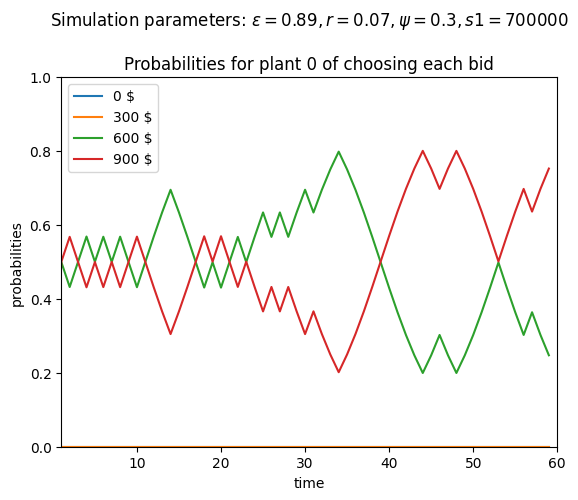

Plot not saved. Remember to set should_save to True if you want to save it.


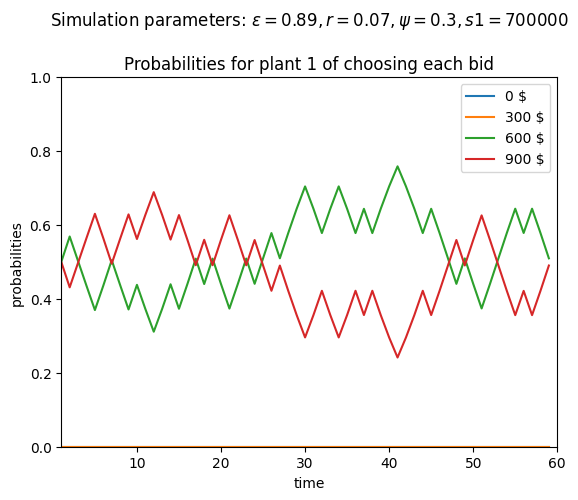

Plot not saved. Remember to set should_save to True if you want to save it.


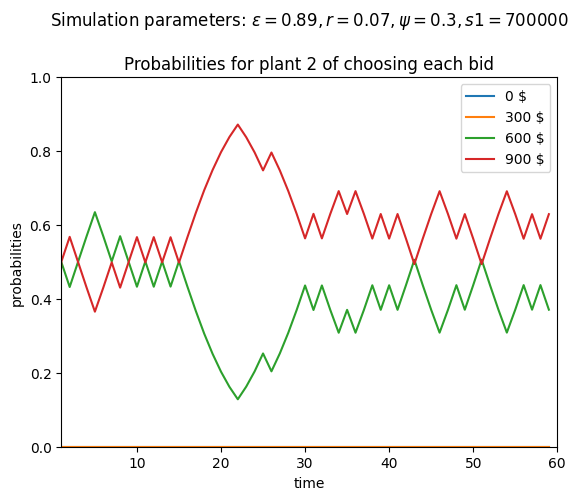

Plot not saved. Remember to set should_save to True if you want to save it.


In [271]:
plant_list = [0, 1, 2]

myplot.bid_probabilities_over_time(prob_data, plant_list, price_increment, t_max, J, ER_params, should_save = False, saving_directory = '.', should_show = True, debug = False)


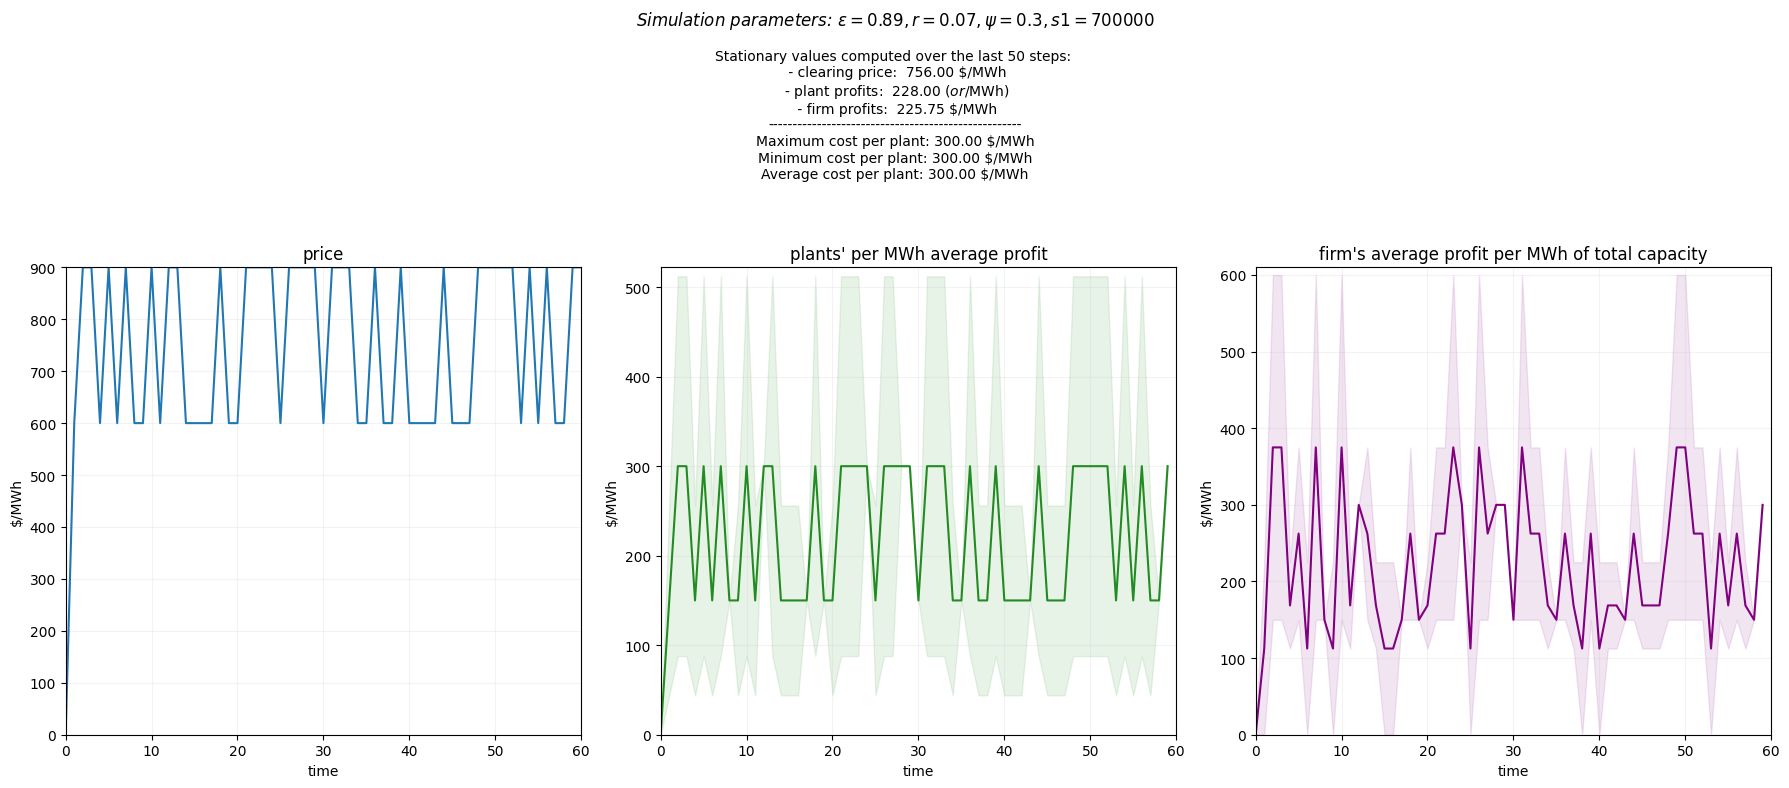

Plot not saved. Remember to set should_save to True if you want to save it.


In [272]:
myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management)

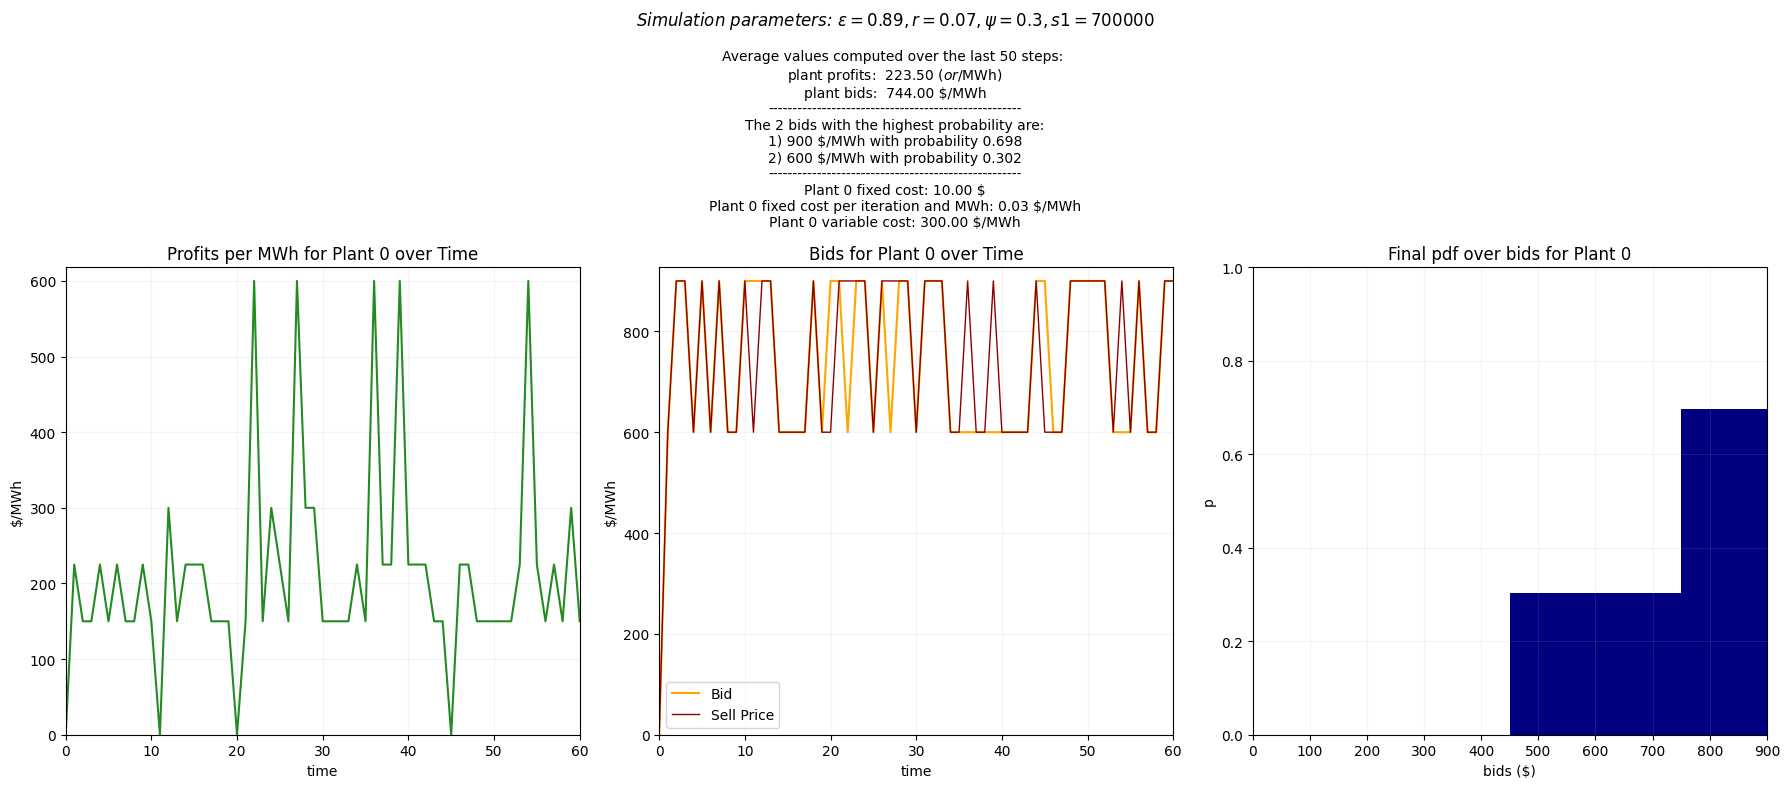

Plot not saved. Remember to set should_save to True if you want to save it.


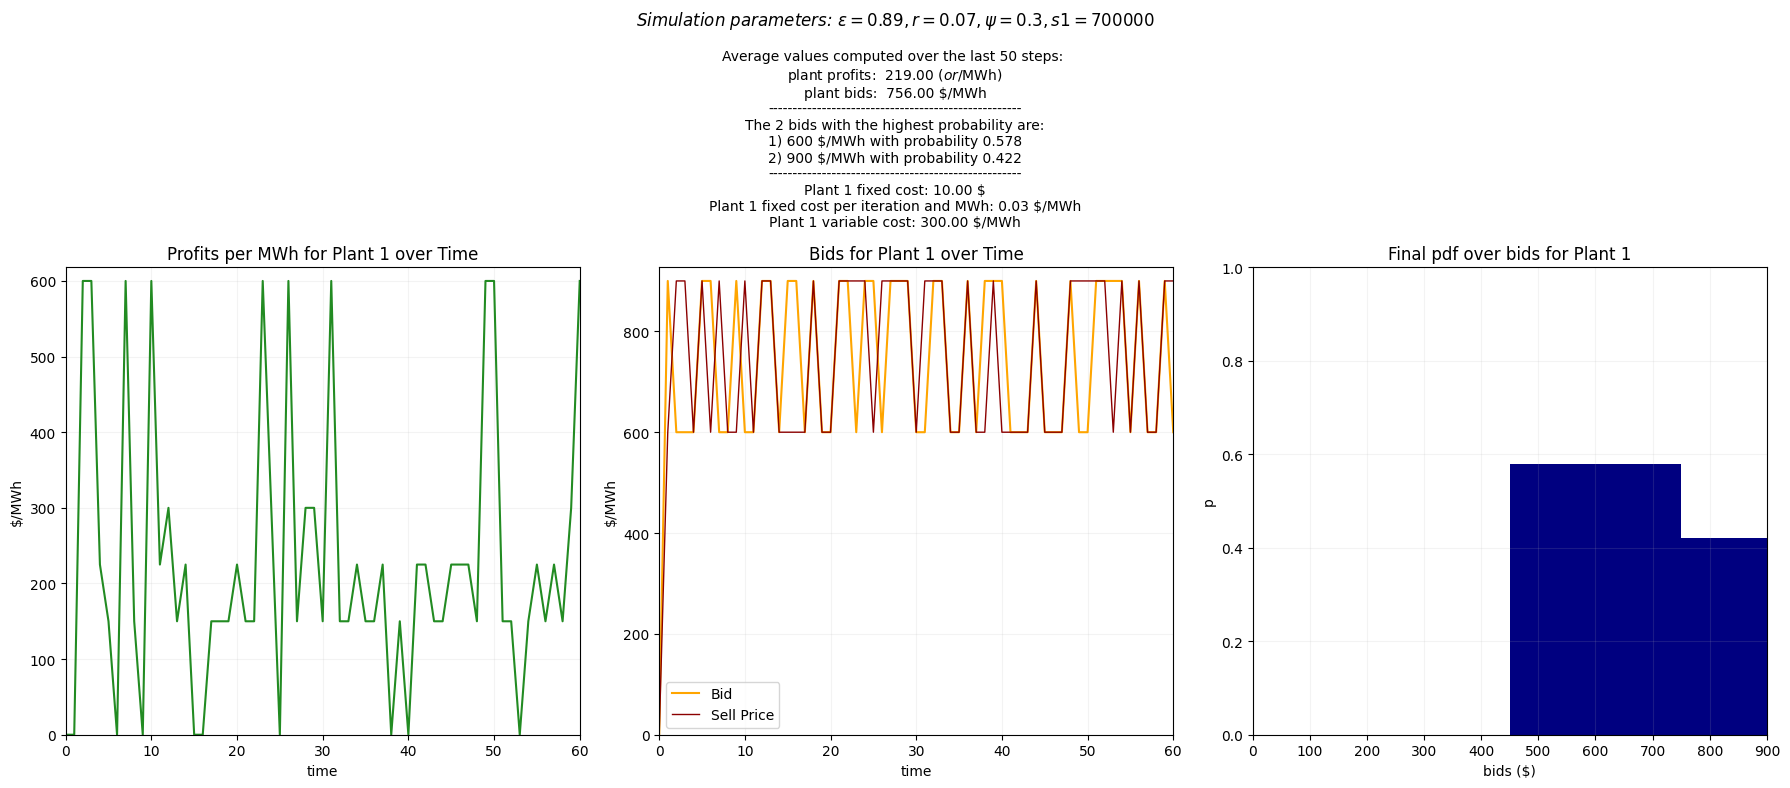

Plot not saved. Remember to set should_save to True if you want to save it.


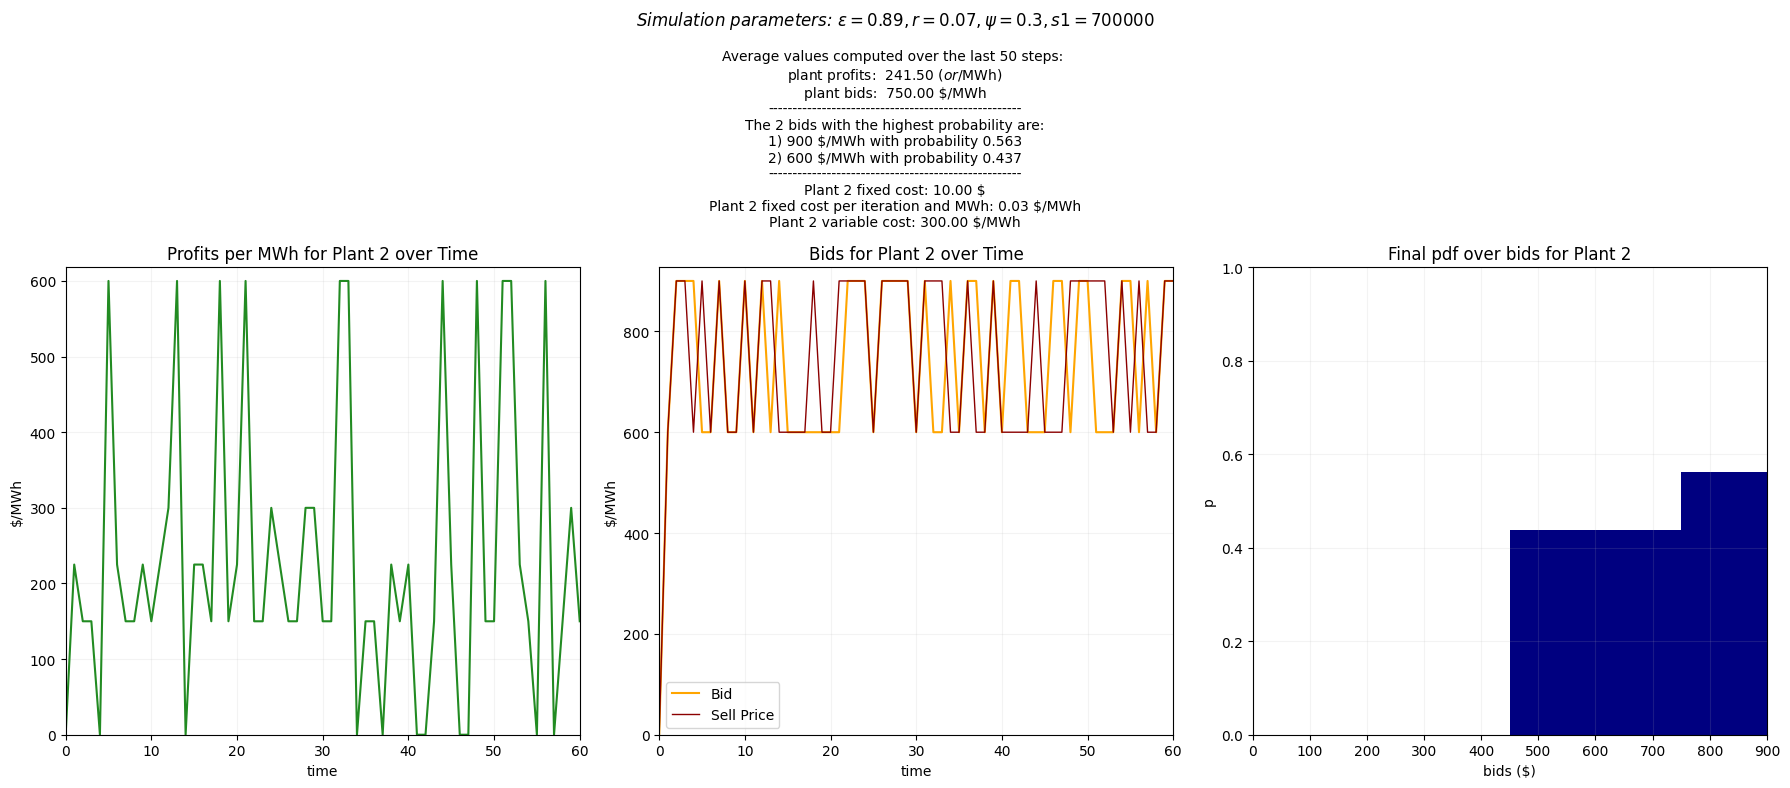

Plot not saved. Remember to set should_save to True if you want to save it.


In [273]:
save_path = ''
plant_ID = 0
myplot.plant_overview(database_path, plant_ID, t_max, plant_profits_data, bid_data, price_increment, prices_data_list, prob_data, ER_params, profits_per = 'MWh', timestep_in_days = timestep_in_days, should_save = False, save_path = save_path, should_show = True)
plant_ID = 1
myplot.plant_overview(database_path, plant_ID, t_max, plant_profits_data, bid_data, price_increment, prices_data_list, prob_data, ER_params, profits_per = 'MWh', timestep_in_days = timestep_in_days, should_save = False, save_path = save_path, should_show = True)
plant_ID = 2
myplot.plant_overview(database_path, plant_ID, t_max, plant_profits_data, bid_data, price_increment, prices_data_list, prob_data, ER_params, profits_per = 'MWh', timestep_in_days = timestep_in_days, should_save = False, save_path = save_path, should_show = True)

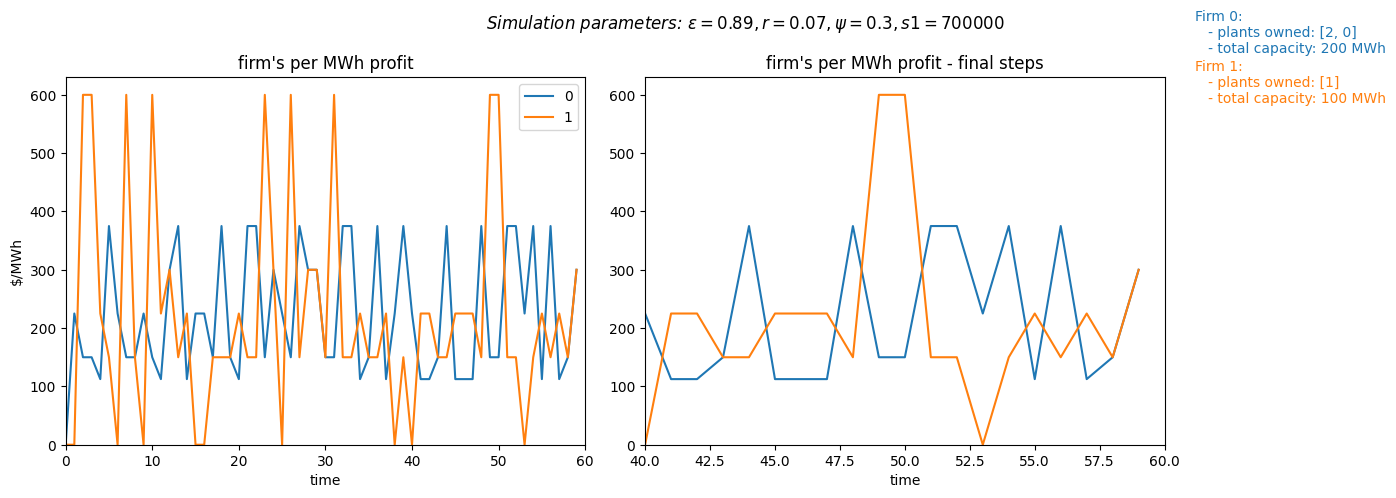

Plot not saved. Remember to set should_save to True if you want to save it.


In [274]:
myplot.firm_profits(firm_profits_data, firm_portfolios_dict, structured_firm_dict, profits_per='MWh', t_max = t_max, ER_params=ER_params)

[0.89, 0.07, 0.0, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
[0.89, 0.07, 0.1, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
[0.89, 0.07, 0.2, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
[0.89, 0.07, 0.30000000000000004, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
[0.89, 0.07, 0.4, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
[0.89, 0.07, 0.5, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
[0.89, 0.07, 0.6000000000000001, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
[0.89, 0.07, 0.7000000000000001, 700000]
...saving simulation results...
Done!
...saving prices timeseries in same folder...
Done.
[0.89, 0.07, 0.8, 700000]


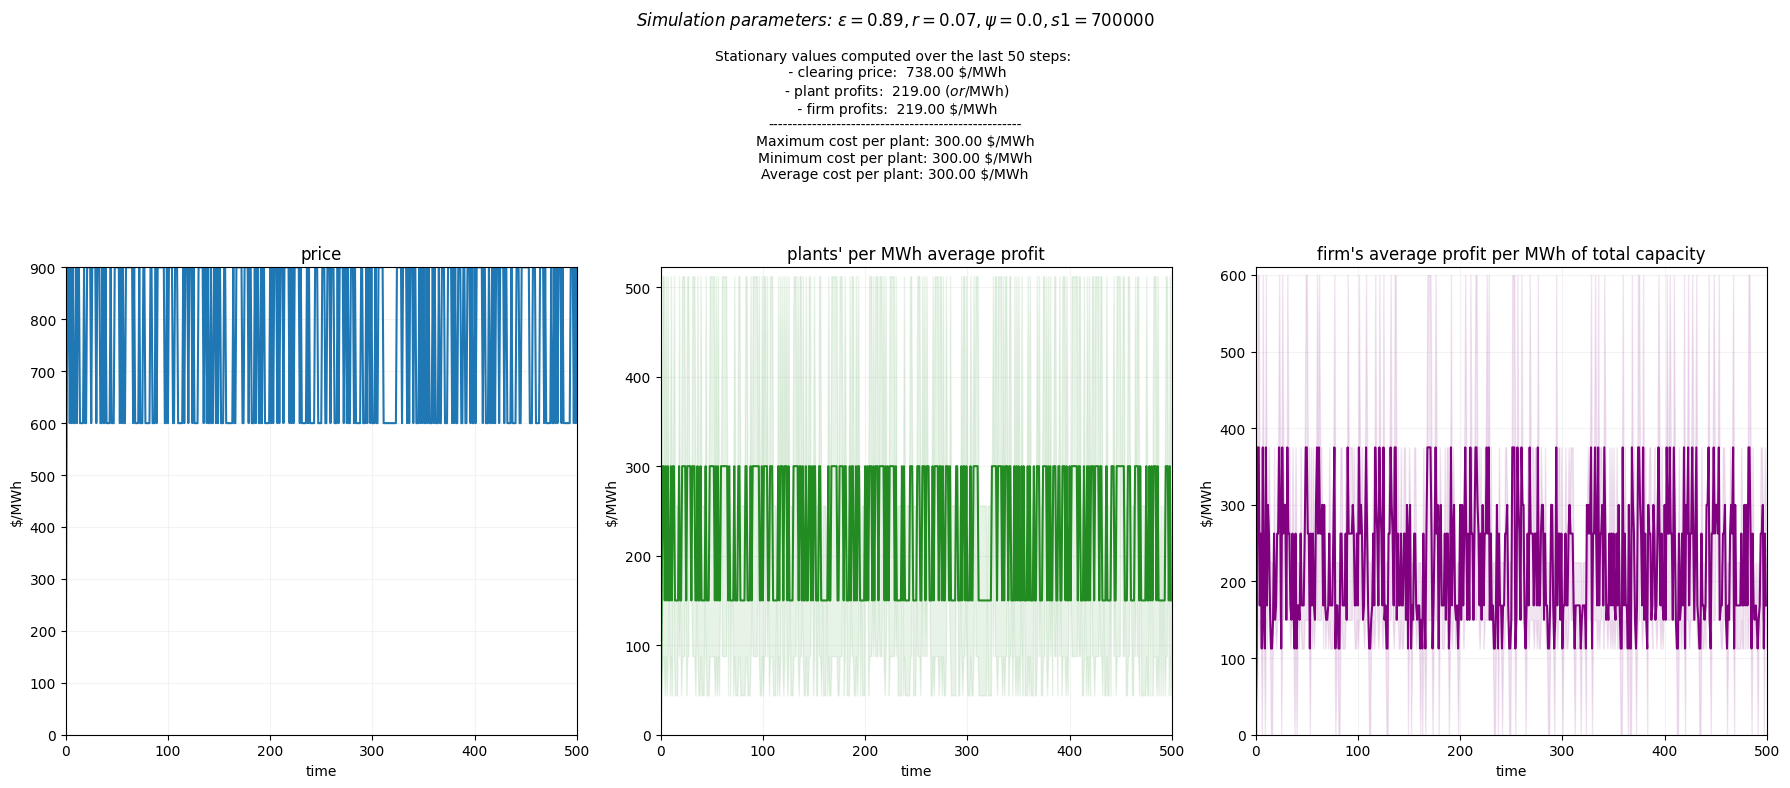

Plot not saved. Remember to set should_save to True if you want to save it.


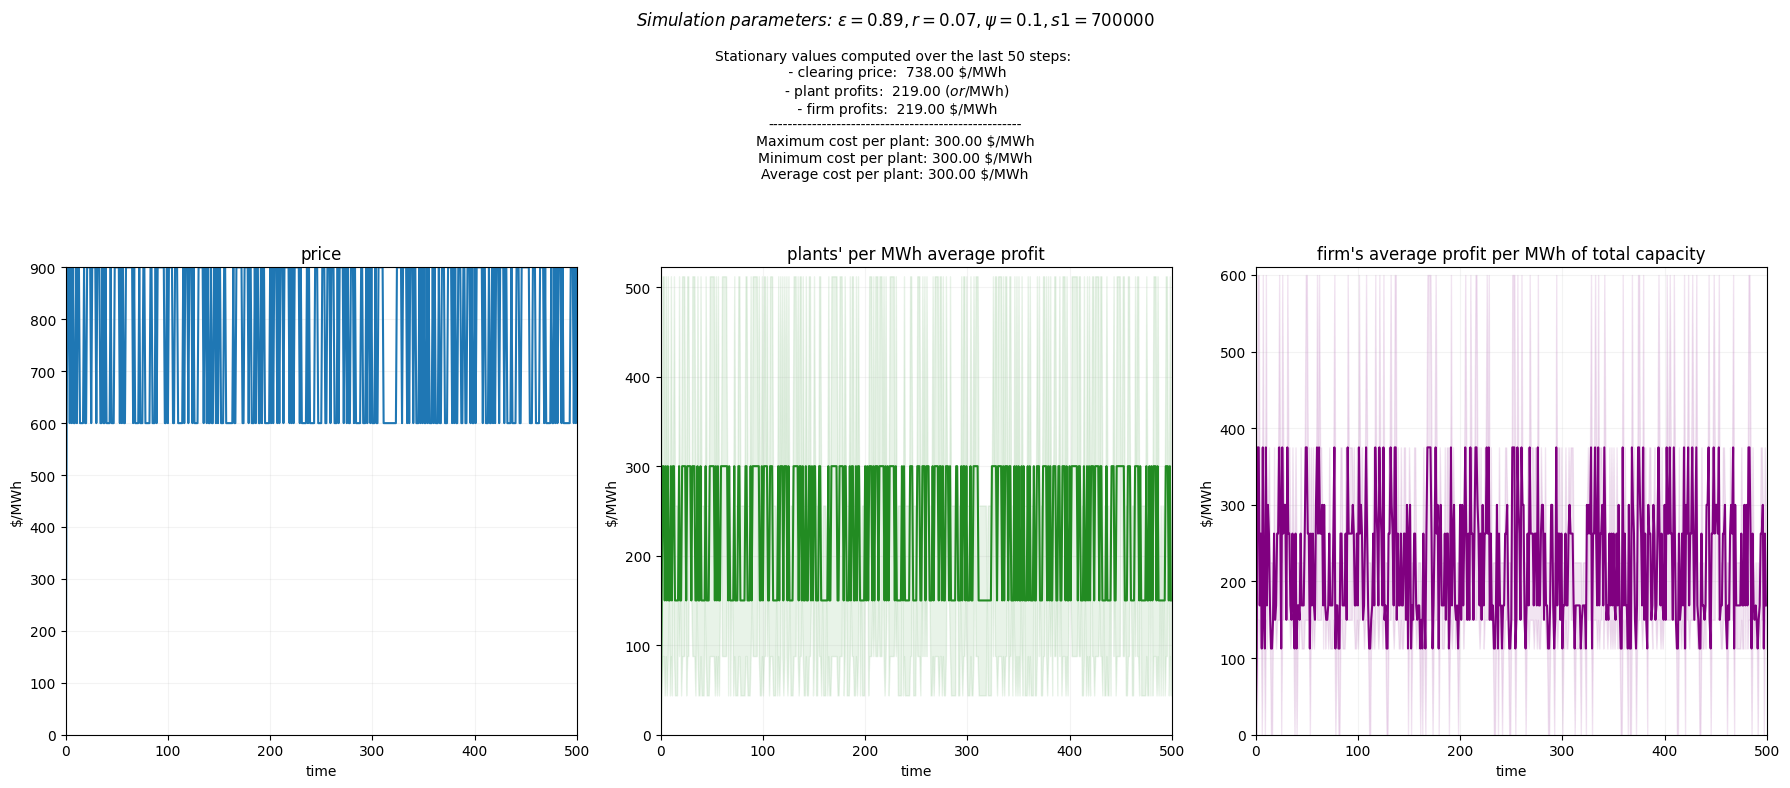

Plot not saved. Remember to set should_save to True if you want to save it.


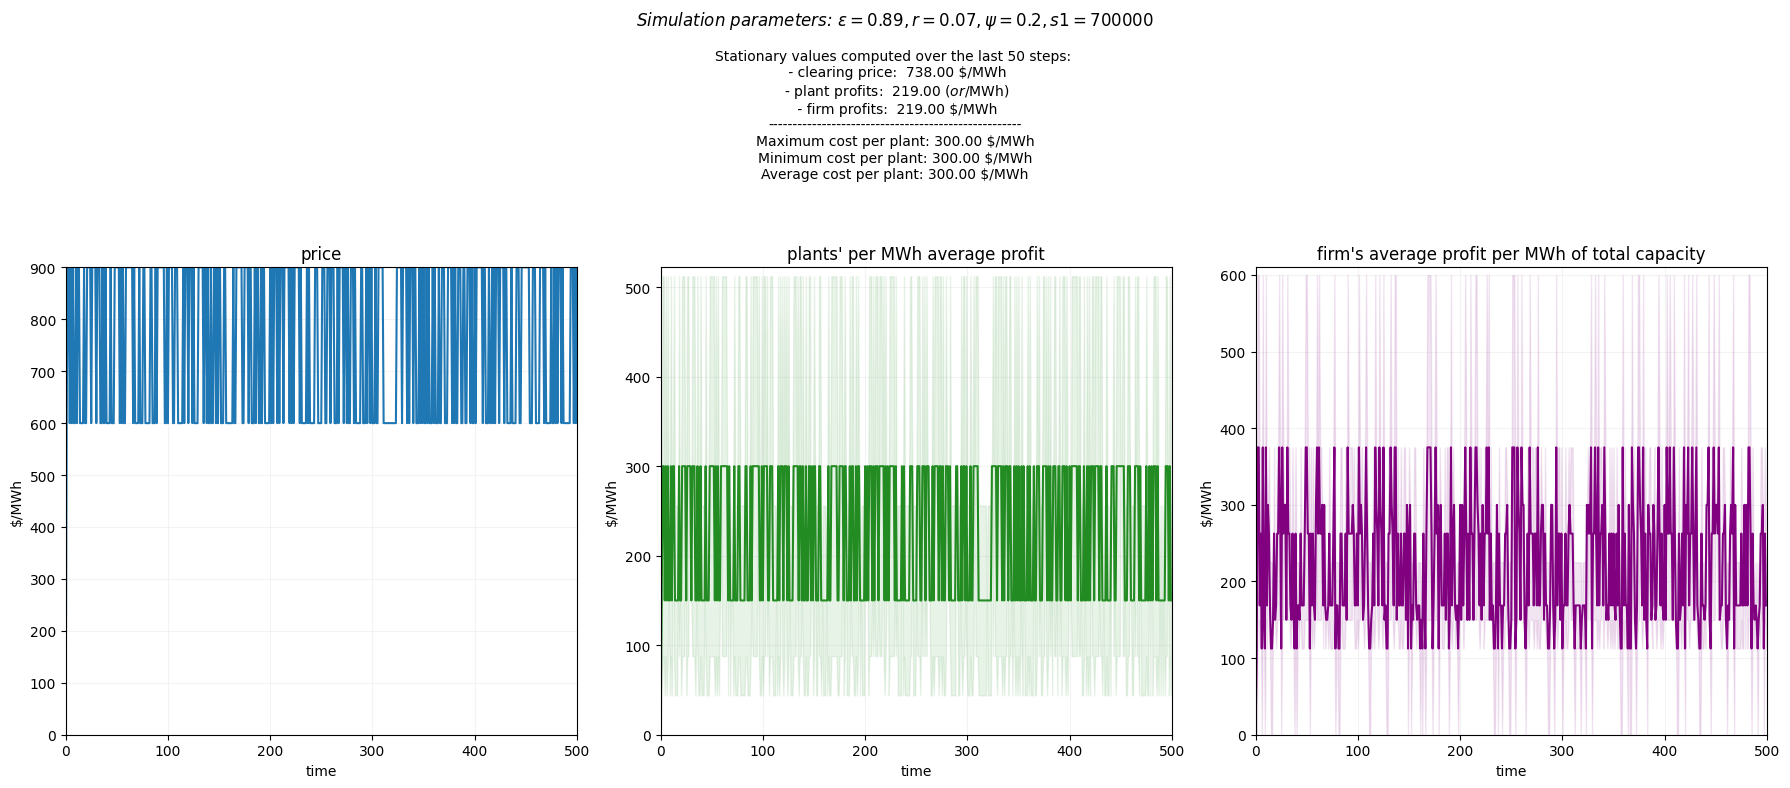

Plot not saved. Remember to set should_save to True if you want to save it.


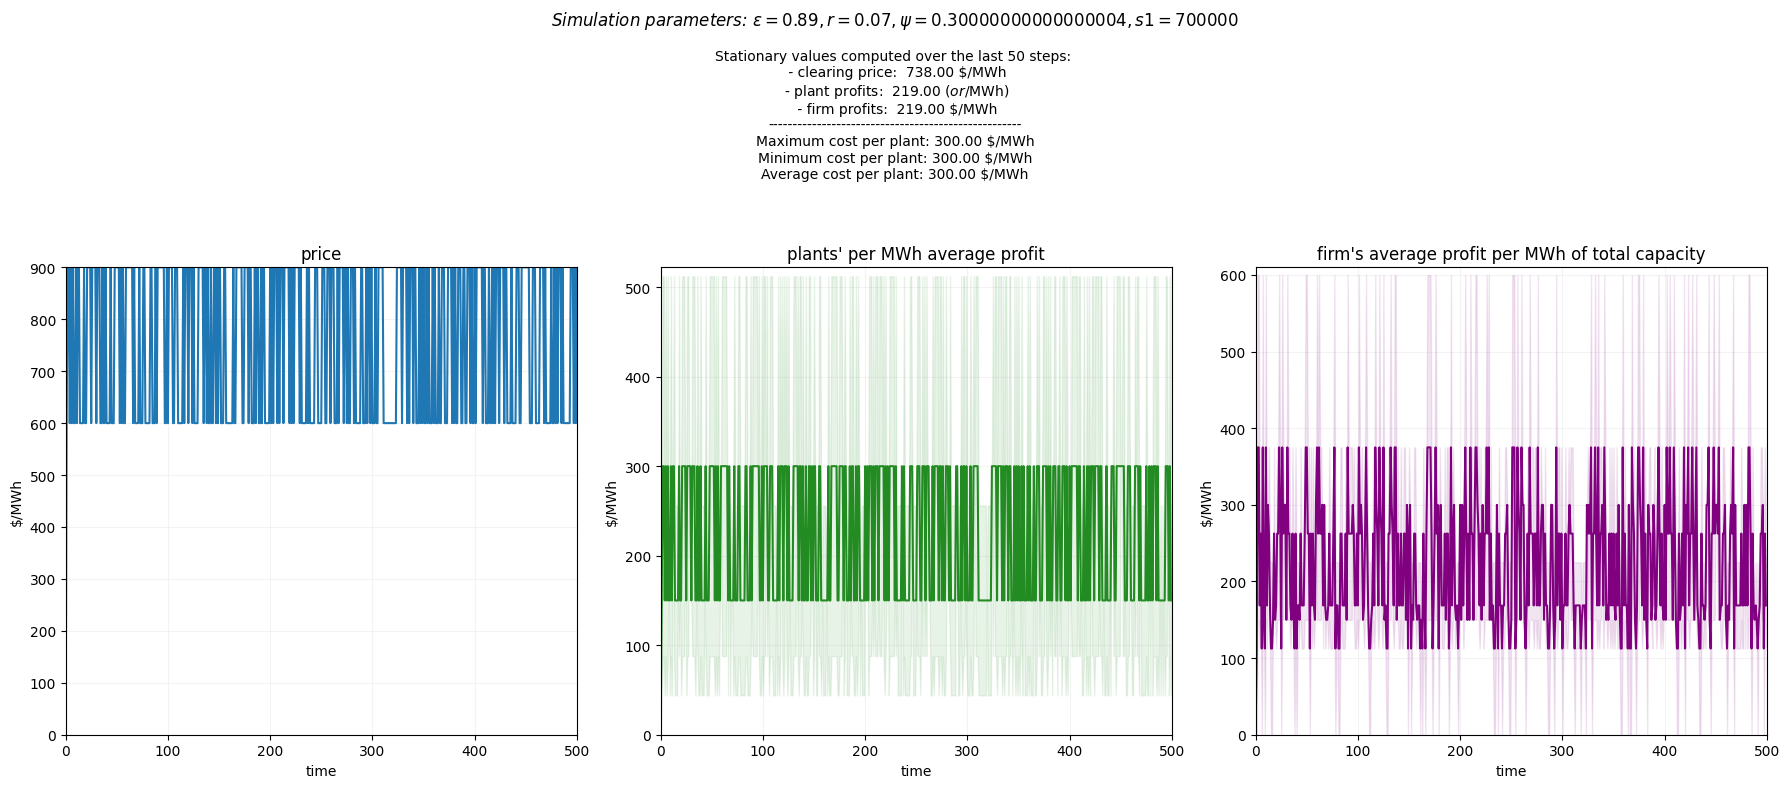

Plot not saved. Remember to set should_save to True if you want to save it.


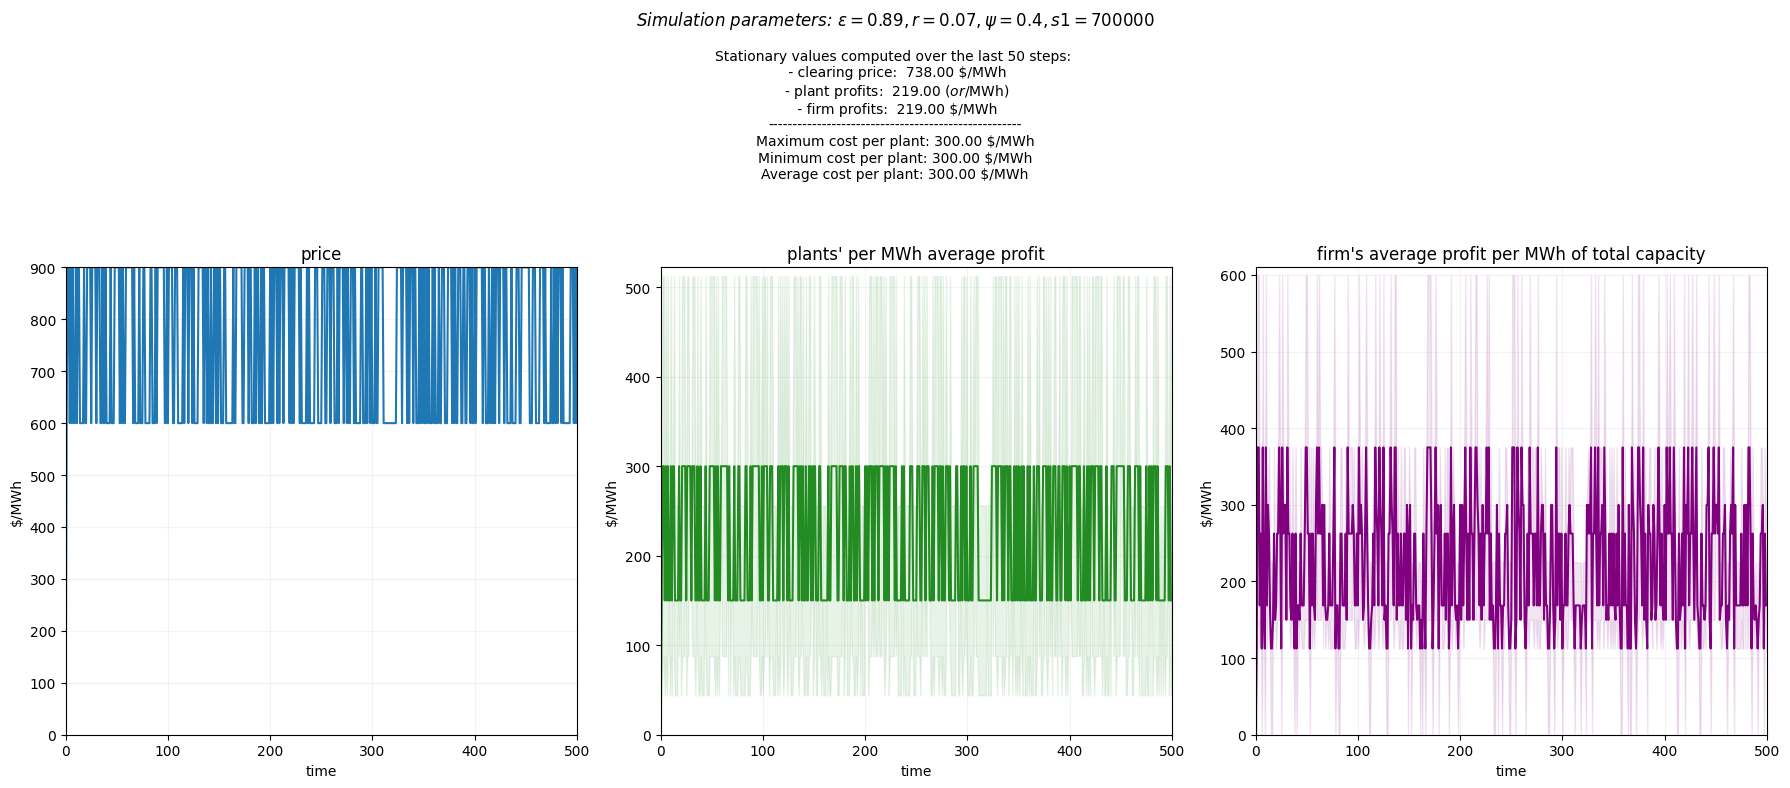

Plot not saved. Remember to set should_save to True if you want to save it.


Plot not saved. Remember to set should_save to True if you want to save it.


Plot not saved. Remember to set should_save to True if you want to save it.


Plot not saved. Remember to set should_save to True if you want to save it.


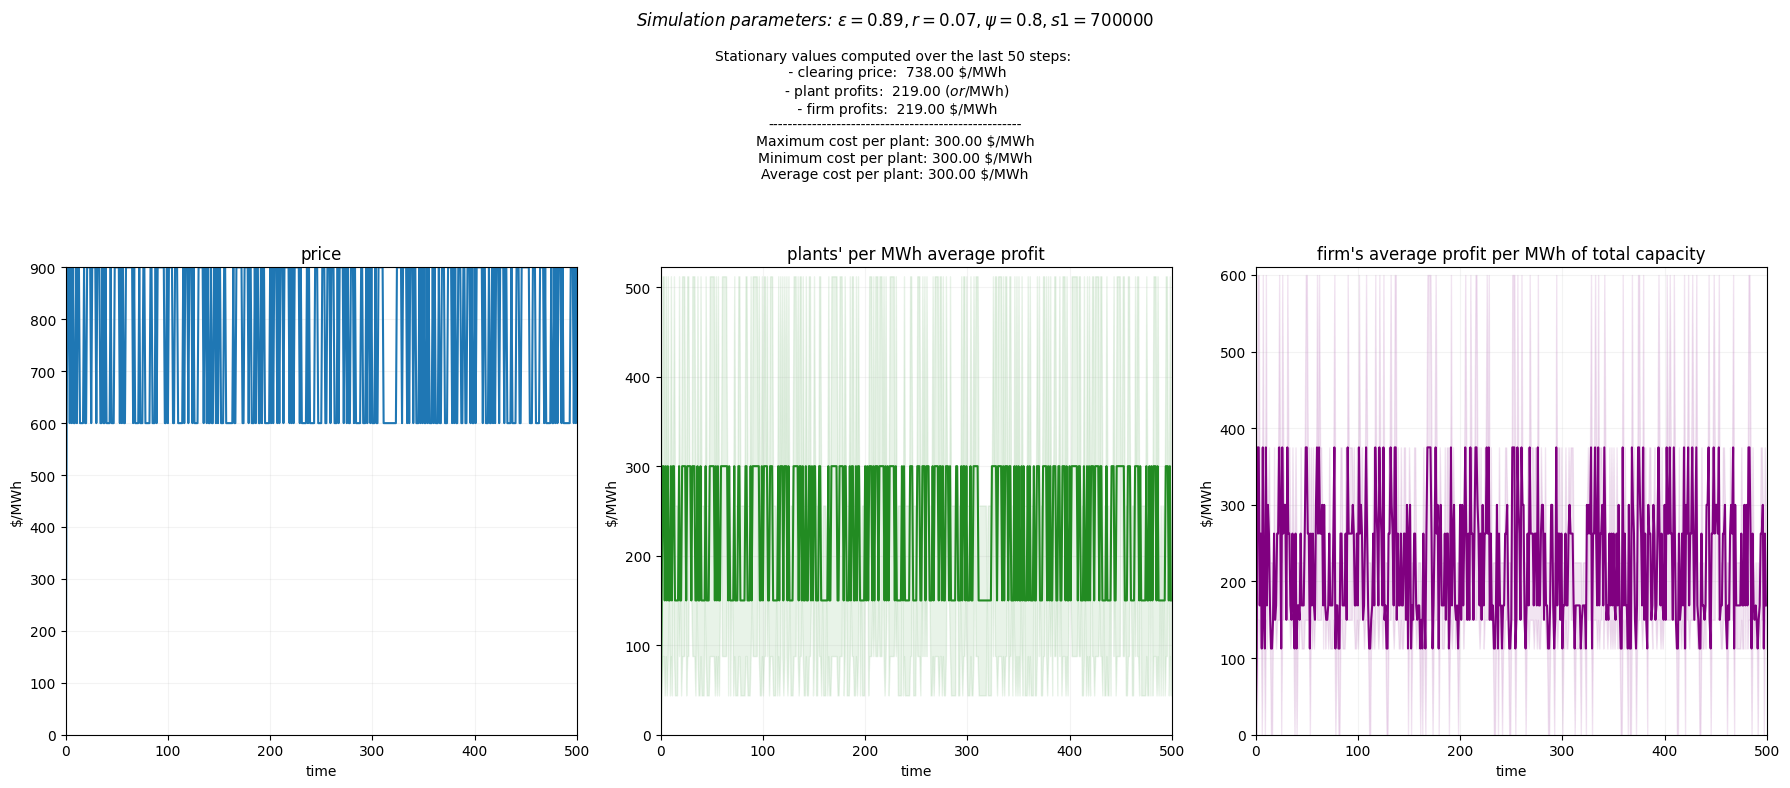

Plot not saved. Remember to set should_save to True if you want to save it.


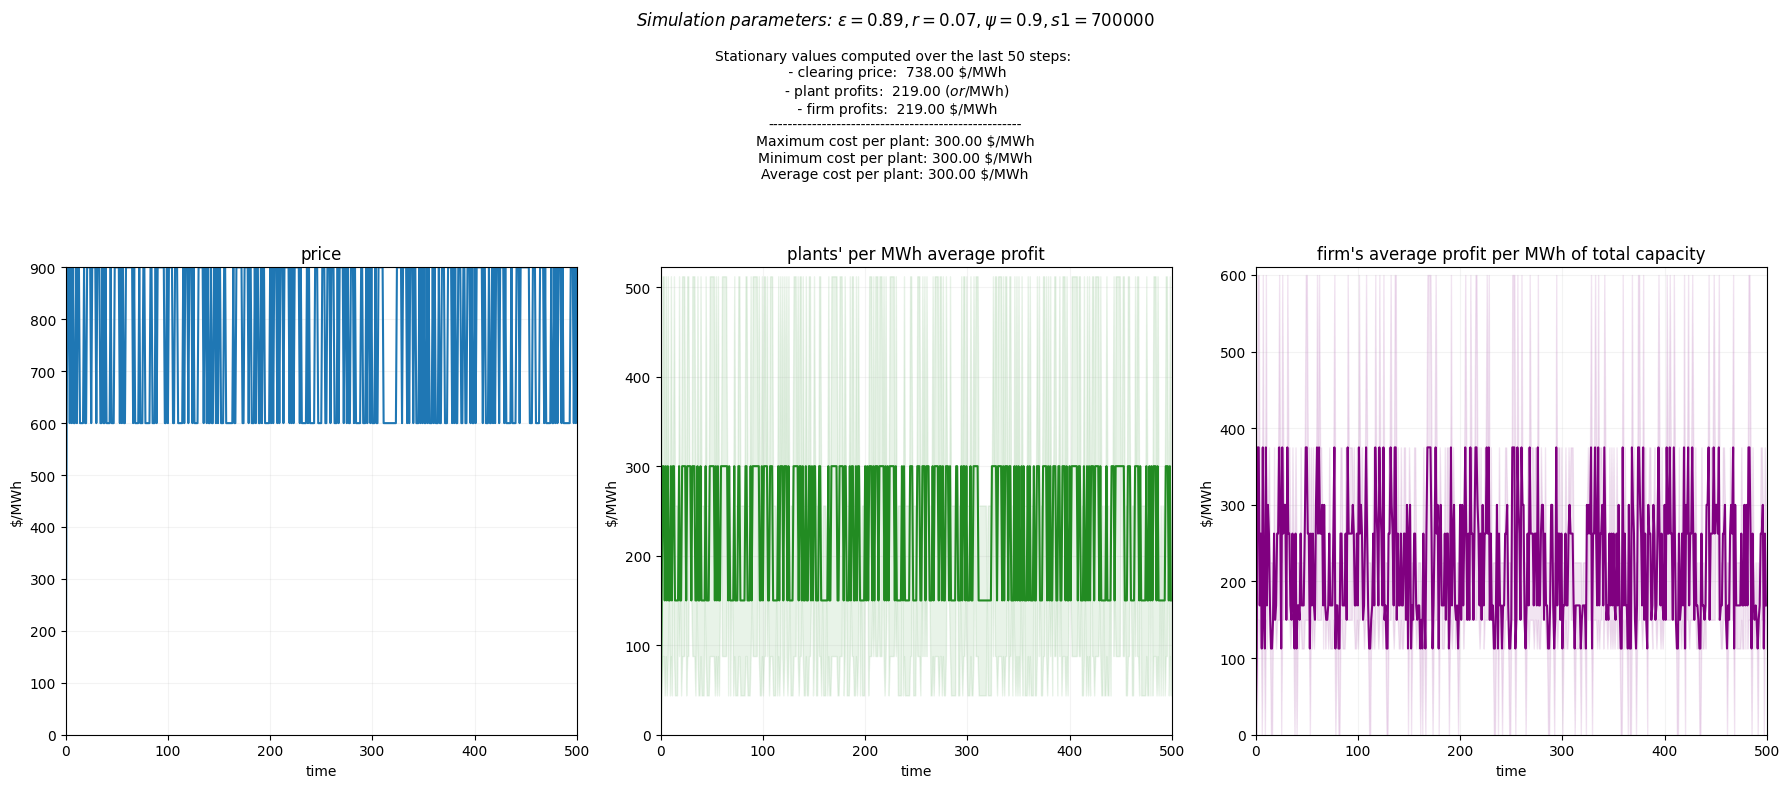

Plot not saved. Remember to set should_save to True if you want to save it.


Plot not saved. Remember to set should_save to True if you want to save it.


In [275]:
psis = np.arange(0,1.1, 0.1)
csv_filenames_dict = {}
for psi in psis:
    epsilon = 0.89
    r = 0.07
    s1 = 700000

    ER_params = [epsilon, r, psi, s1]
    print(ER_params)

    costs_management = 'both_costs'
    run_type = 'multiple'
    timestep_in_days = 1

    t_max = 500
    demand_type = 'constant'
    output_path = './Simulation_Results/Debug/three_plants_two_firms'

    simulation = Model(N, M, J, price_increment, ER_params, seed, costs_management, timestep_in_days, run_type)
    csv_filenames, prob_data = simulation.run(database_path, t_max, plant_ownership_dict, firm_portfolios_dict, demand_type, output_path, run_ID=0)
    csv_filenames_dict[psi] = csv_filenames

for psi in psis:
    csv_filenames = csv_filenames_dict[psi]
    prices_data_list = utils.load_prices_from_csv(csv_filenames['price_data'])
    chosen_action_data = utils.load_dict_data_from_csv(csv_filenames['chosen_action_data'], data_to_load='chosen_action_data')
    bid_data = utils.load_dict_data_from_csv(csv_filenames['bid_data'], data_to_load='bid_data')
    plant_profits_data = utils.load_dict_data_from_csv(csv_filenames['plant_profits_data'], data_to_load='plant_profits_data')
    firm_profits_data = utils.load_dict_data_from_csv(csv_filenames['firm_profits_data'], data_to_load='firm_profits_data')
    ER_params = [epsilon, r, psi, s1]
    myplot.simulation_overview(database_path, min_price, max_price, prices_data_list, plant_profits_data, N, firm_profits_data, firm_portfolios_dict, structured_firm_dict, t_max, ER_params, profits_per = 'MWh', costs_management=costs_management)
